In [1]:
import pandas as pd # standard python data library
import geopandas as gp # the geo-version of pandas
import numpy as np 
import os
import fiona
from statistics import mean, median
from pandas import read_csv
gp.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw' #To load KML files
import string
import xml.etree.ElementTree as et
import re
from collections import Counter

pd.options.display.max_columns = 999

# Florida

## VEST Documentation

Election results from the Florida Department of State (https://dos.myflorida.com/elections/data-statistics/elections-data/precinct-level-election-results/)

Precinct results from several sources.  
- Alachua, Bay, Bradford, Brevard, Calhoun, Citrus, Clay, Dixie, Escambia, Hardee, Hendry, Hernando, Indian River, Lafayette and Sarasota come from the Department of State.  
- Broward, Gadsden, Gilchrist, Manatee, Nassau, Santa Rosa, St. Johns, St. Lucie, and Union are from the Orlando Sentinel's precinct map for the 2016 presidential primary (http://interactive.orlandosentinel.com/elections/2016/presidential-primary/results/dem.html).  
- Baker, Charlotte, Franklin, Glades, Holmes, Jackson, Jefferson, Levy, Liberty, Madison, Monroe, Okeechobee, Orange, Seminole, Suwannee, Taylor, Wakulla, Walton, and Washinton come from the U.S. Census Bureau's 2020 Redistricting Data Program.  
- Collier, Columbia, DeSoto, Duval, Flagler, Gulf, Highlands, Hillsborough, Lake, Lee, Leon, Marion, Martin, Miami-Dade, Okaloosa, Osceola, Palm Beach, Pasco, Pinellas, Polk, Putnam, Sumter, and Volusia come from the counties.
- Hamilton was drawn based on a geocoded voter registration file.  
- Edits were made to Brevard, Charlotte, Escambia, Franklin, Indian River, Jefferson, Lafayette, Lake, and Lee, Miami-Dade, and St. Johns based on the voter registration file.  

Lake 108, Osceola 999, Palm Beach 8002, Seminole 900s, and Monroe's "Cumulative" precinct (the latter appears on the county's detailed results but not the DOS's precinct results file) don't have geography. Brevard 999, Broward Z073, Collier 450, Flagler 999, Hillborough 999, Leon 9000, Miami-Dade 100, and Pinellas 512 do have geography, but they are just the county election offices. Both groups represent some type of vote not assigned to a particular geography, like UOCAVA results, so these were distributed across the county by candidate proportional to the vote each precinct recorded.

G20PRERTRU - Donald J. Trump (Republican Party)  
G20PREDBID - Joseph R. Biden (Democratic Party)  
G20PRELJOR - Jo Jorgensen (Libertarian Party)  
G20PREODEL - Roque "Rocky" De La Fuente (Reform Party)  
G20PRESLAR - Gloria La Riva (Party for Socialism and Liberation)  
G20PREGHAW - Howie Hawkin (Green Party)  
G20PRECBLA - Don Blankenship (Constitution Party)  
G20PREOWRI - Write-in Votes  

## Load VEST File

In [2]:
vest_fl_20 = gp.read_file("./raw-from-source/VEST/fl_2020/fl_2020.shp")

In [3]:
vest_fl_20.columns

Index(['pct_std', 'county', 'precinct', 'G20PRERTRU', 'G20PREDBID',
       'G20PRELJOR', 'G20PREODEL', 'G20PRESLAR', 'G20PREGHAW', 'G20PRECBLA',
       'G20PREOWRI', 'geometry'],
      dtype='object')

In [4]:
data_columns = [col for col in vest_fl_20.columns if "G20" in col]

## Load Election Results

Fields and codes data https://files.floridados.gov/media/694099/precinct-level-results-data-definition-field-codes.pdfF

In [5]:
#This Data is from the FL department of state, and can only be downloaded county by county
all_files = os.listdir("./raw-from-source/Election_Results/2020-general-election-rev/")

In [6]:
#Minor processing note: For the FRA file, I replaced ""AJ"" w/ "AJ", so the load works

In [7]:
#Check that all files have the same number of columns
for i in all_files:
    if i !=".DS_Store":
        ref = "./raw-from-source/Election_Results/2020-general-election-rev/"
        file_ref = ref+i
        file_prev = pd.read_csv(file_ref,sep="\t",engine='python',index_col=None, header=None)
        if (file_prev.shape[1]!=19):
            print(i)
        #print(file_prev.shape)
    
#All the files have 19 columns, so they should be good to combine

In [8]:
li = []
for i in all_files:
    if i not in [".DS_Store","DAD_PctResults20201103recount.txt","BRO_PctResults20201103recount.txt"]:
        ref = "./raw-from-source/Election_Results/2020-general-election-rev/"
        file_ref = ref+i
        file_prev = pd.read_csv(file_ref,sep="\t",engine='python',index_col=None, header=None)
        li.append(file_prev)
frame = pd.concat(li, axis=0, ignore_index=True)
print(frame.shape)

(553307, 19)


In [9]:
frame[11].unique()

array(['President of the United States', 'Representative in Congress',
       'State Representative',
       'Clerk of the Circuit Court and Comptroller',
       'Supervisor of Elections', 'County Commissioner',
       'Retention of Carlos G. Muñiz', 'Retention of Alan O. Forst',
       'Retention of Mark W. Klingensmith',
       'Retention of Martha C. Warner',
       'Amendment No. 1: Citizenship Requirement to Vote in Florida Elections',
       'Amendment No. 2: Raising Florida’s Minimum Wage',
       'Amendment No. 3: All Voters Vote in Primary Elections for State Legislature, Governor, and Cabinet',
       'Amendment No. 4: Voter Approval of Constitutional Amendments',
       'Amendment No. 5: Limitations on Homestead Property Tax Assessments; increased portability period to transfer accrued benefit',
       'Amendment No. 6: Ad Valorem Tax Discount for Spouses of Certain Deceased Veterans Who Had Permanent, Combat-Related Disabilities',
       'State Senator', 'Sheriff', 'Propert

In [10]:
len(frame[(frame[0] == "ALA")][6].unique())

62

https://files.floridados.gov/media/694099/precinct-level-results-data-definition-field-codes.pdf

In [11]:
col_rename_dict = {0: 'County Code (Three-character abbreviation)',
 1: 'County Name',
 2: 'Election Number',
 3: 'Election Date',
 4: 'Election Name',
 5: 'Unique Precinct Identifier',
 6: 'Precinct Polling Location',
 7: 'Total Registered Voters',
 8: 'Total Registered Republicans',
 9: 'Total Registered Democrats',
 10: 'Total Registered All Other Parties',
 11: 'Contest Name',
 12: 'District',
 13: 'Contest Code (Florida’s 6 digit contest codes)',
 14: 'Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes',
 15: 'Candidate Party (abbreviation)',
 16: 'Candidate Florida Voter Registration System ID Number',
 17: 'DOE Assigned Candidate Number or Retention/Issue Number',
 18: 'Vote Total'}

In [12]:
frame.rename(columns = col_rename_dict, inplace = True)

In [13]:
races_list = races_list = ['President of the United States', 'Representative in Congress',
       'State Representative','State Senator','Retention of Carlos G. Muñiz','Amendment No. 1: Citizenship Requirement to Vote in Florida Elections',
       'Amendment No. 2: Raising Florida’s Minimum Wage',
       'Amendment No. 3: All Voters Vote in Primary Elections for State Legislature, Governor, and Cabinet',
       'Amendment No. 4: Voter Approval of Constitutional Amendments',
       'Amendment No. 5: Limitations on Homestead Property Tax Assessments; increased portability period to transfer accrued benefit',
       'Amendment No. 6: Ad Valorem Tax Discount for Spouses of Certain Deceased Veterans Who Had Permanent, Combat-Related Disabilities']

In [14]:
#Filter to the presidential results
frame =frame[frame['Contest Name'].isin(races_list)]

#Filter out the OverVotes and UnderVotes
filtered_frame = frame[~frame['Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes'].isin(['OverVotes', 'UnderVotes'])]

#Clean up the precinct column
filtered_frame['Precinct Polling Location'] = filtered_frame['Precinct Polling Location'].astype(str)

#Deal with Dade County
filtered_frame["mod_col"]=filtered_frame.apply(lambda row:int(float(row['Precinct Polling Location'].split("PRECINCT ")[1])) if row['County Code (Three-character abbreviation)']=="DAD" else row['Unique Precinct Identifier'], axis=1)

#Make the precinct column at least 4 digits
filtered_frame["mod_col"]=filtered_frame["mod_col"].astype(str)
filtered_frame["modified_pre"]=filtered_frame["mod_col"].str.zfill(4)

#Make a column with the 3 letter county code and the precincts
filtered_frame["pct_std"]=filtered_frame['County Code (Three-character abbreviation)']+filtered_frame["modified_pre"]

<ipython-input-14-5edbeda0f2eb>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame['Precinct Polling Location'] = filtered_frame['Precinct Polling Location'].astype(str)
<ipython-input-14-5edbeda0f2eb>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["mod_col"]=filtered_frame.apply(lambda row:int(float(row['Precinct Polling Location'].split("PRECINCT ")[1])) if row['County Code (Three-character abbreviation)']=="DAD" else row['Unique Precinct Identifier'], axis=1)
<ipython-input

In [15]:
# Cast the contest name and code columns to string to make the pivot col
filtered_frame["Contest Name"] = filtered_frame["Contest Name"].astype(str)
filtered_frame["Contest Code (Florida’s 6 digit contest codes)"] = filtered_frame["Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes"].astype(str)

<ipython-input-15-46da4f0e8365>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["Contest Name"] = filtered_frame["Contest Name"].astype(str)
<ipython-input-15-46da4f0e8365>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["Contest Code (Florida’s 6 digit contest codes)"] = filtered_frame["Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes"].astype(str)


In [16]:
filtered_frame['Candidate Party (abbreviation)'] = filtered_frame['Candidate Party (abbreviation)'].map({' ':'WRI'}).fillna(filtered_frame['Candidate Party (abbreviation)'])

<ipython-input-16-cc08b28a7227>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame['Candidate Party (abbreviation)'] = filtered_frame['Candidate Party (abbreviation)'].map({' ':'WRI'}).fillna(filtered_frame['Candidate Party (abbreviation)'])


In [17]:
filtered_frame['Candidate Party (abbreviation)'].unique()

array(['REP', 'DEM', 'LPF', 'REF', 'PSL', 'GRE', 'CPF', 'WRI', 'NPA',
       'NOP'], dtype=object)

In [18]:
# Create the pivot column with the contest name and the candidate
filtered_frame["pivot_col"] = filtered_frame["Contest Name"] + "-" + filtered_frame["Contest Code (Florida’s 6 digit contest codes)"] + "-" + "PARTY:" +filtered_frame['Candidate Party (abbreviation)']  

<ipython-input-18-fe582c8917a9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["pivot_col"] = filtered_frame["Contest Name"] + "-" + filtered_frame["Contest Code (Florida’s 6 digit contest codes)"] + "-" + "PARTY:" +filtered_frame['Candidate Party (abbreviation)']


In [19]:
# Where it exists, add in the district to the pivot column
filtered_frame["pivot_col"] = np.where(filtered_frame["District"]!=" ",filtered_frame["pivot_col"] + "-" + filtered_frame["District"], filtered_frame["pivot_col"])

<ipython-input-19-d12f4a46ad53>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_frame["pivot_col"] = np.where(filtered_frame["District"]!=" ",filtered_frame["pivot_col"] + "-" + filtered_frame["District"], filtered_frame["pivot_col"])


### Pivot the Data

In [20]:
filtered_frame[filtered_frame["Contest Name"]== "Representative in Congress"]

,County Code (Three-character abbreviation),County Name,Election Number,Election Date,Election Name,Unique Precinct Identifier,Precinct Polling Location,Total Registered Voters,Total Registered Republicans,Total Registered Democrats,Total Registered All Other Parties,Contest Name,District,Contest Code (Florida’s 6 digit contest codes),Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes,Candidate Party (abbreviation),Candidate Florida Voter Registration System ID Number,DOE Assigned Candidate Number or Retention/Issue Number,Vote Total,mod_col,modified_pre,pct_std,pivot_col
110,OKE,Okeechobee,10866,11/03/2020,2020 General Election,1,1-ABIDING HOPE WORSHIP CENTER,1593,0,0,0,Representative in Congress,District 17,Greg Steube,Greg Steube,REP,105486919,75229,929,1,0001,OKE0001,Representative in Congress-Greg Steube-PARTY:R...
111,OKE,Okeechobee,10866,11/03/2020,2020 General Election,2,2-BASINGER COMMUNITY CENTER,849,0,0,0,Representative in Congress,District 17,Greg Steube,Greg Steube,REP,105486919,75229,515,2,0002,OKE0002,Representative in Congress-Greg Steube-PARTY:R...
112,OKE,Okeechobee,10866,11/03/2020,2020 General Election,3,3-OAKVIEW BAPTIST CHURCH,2449,0,0,0,Representative in Congress,District 17,Greg Steube,Greg Steube,REP,105486919,75229,1527,3,0003,OKE0003,Representative in Congress-Greg Steube-PARTY:R...
113,OKE,Okeechobee,10866,11/03/2020,2020 General Election,4,4-OKEECHOBEE CIVIC CENTER,3021,0,0,0,Representative in Congress,District 17,Greg Steube,Greg Steube,REP,105486919,75229,1031,4,0004,OKE0004,Representative in Congress-Greg Steube-PARTY:R...
114,OKE,Okeechobee,10866,11/03/2020,2020 General Election,5,5-FREEDOM RANCH,1567,0,0,0,Representative in Congress,District 17,Greg Steube,Greg Steube,REP,105486919,75229,807,5,0005,OKE0005,Representative in Congress-Greg Steube-PARTY:R...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
551503,GAD,Gadsden,10866,11/03/2020,2020 General Election,21,Pre 21 Green Shade AME Church,566,0,0,0,Representative in Congress,District 5,Al Lawson,Al Lawson,DEM,104987227,75494,266,21,0021,GAD0021,Representative in Congress-Al Lawson-PARTY:DEM...
551504,GAD,Gadsden,10866,11/03/2020,2020 General Election,22,Pre 22 Second Elizabeth Church,711,0,0,0,Representative in Congress,District 5,Al Lawson,Al Lawson,DEM,104987227,75494,424,22,0022,GAD0022,Representative in Congress-Al Lawson-PARTY:DEM...
551505,GAD,Gadsden,10866,11/03/2020,2020 General Election,23,Pre 23 New Direction Christian,787,0,0,0,Representative in Congress,District 5,Al Lawson,Al Lawson,DEM,104987227,75494,397,23,0023,GAD0023,Representative in Congress-Al Lawson-PARTY:DEM...
551506,GAD,Gadsden,10866,11/03/2020,2020 General Election,24,Pre 24 St. Joseph Missionary B,477,0,0,0,Representative in Congress,District 5,Al Lawson,Al Lawson,DEM,104987227,75494,347,24,0024,GAD0024,Representative in Congress-Al Lawson-PARTY:DEM...


In [21]:
# Removing all of the specific party registration data, as it looks like the state doesn't have that
for val in ['Total Registered Republicans','Total Registered Democrats', 'Total Registered All Other Parties']:
    print(filtered_frame[val].unique())

[0]
[0]
[0]


In [22]:
filtered_frame.drop(['Election Number', 'Election Date', 'Total Registered Republicans','Total Registered Democrats', 'Total Registered All Other Parties','Candidate Florida Voter Registration System ID Number','DOE Assigned Candidate Number or Retention/Issue Number'], axis = 1, inplace = True)

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [23]:
filtered_frame[filtered_frame["pct_std"] == "ALA0001"]

,County Code (Three-character abbreviation),County Name,Election Name,Unique Precinct Identifier,Precinct Polling Location,Total Registered Voters,Contest Name,District,Contest Code (Florida’s 6 digit contest codes),Candidate/Retention/IssueName/WriteInsCast/OverVotes/UnderVotes,Candidate Party (abbreviation),Vote Total,mod_col,modified_pre,pct_std,pivot_col
500414,ALA,Alachua,2020 General Election,1,First Baptist Church of Waldo,1540,President of the United States,,Trump / Pence,Trump / Pence,REP,725,1,0001,ALA0001,President of the United States-Trump / Pence-P...
500477,ALA,Alachua,2020 General Election,1,First Baptist Church of Waldo,1540,President of the United States,,Biden / Harris,Biden / Harris,DEM,424,1,0001,ALA0001,President of the United States-Biden / Harris-...
500540,ALA,Alachua,2020 General Election,1,First Baptist Church of Waldo,1540,President of the United States,,Jorgensen / Cohen,Jorgensen / Cohen,LPF,6,1,0001,ALA0001,President of the United States-Jorgensen / Coh...
500603,ALA,Alachua,2020 General Election,1,First Baptist Church of Waldo,1540,President of the United States,,De La Fuente / Richardson,De La Fuente / Richardson,REF,2,1,0001,ALA0001,President of the United States-De La Fuente / ...
500666,ALA,Alachua,2020 General Election,1,First Baptist Church of Waldo,1540,President of the United States,,La Riva / Freeman,La Riva / Freeman,PSL,1,1,0001,ALA0001,President of the United States-La Riva / Freem...
500729,ALA,Alachua,2020 General Election,1,First Baptist Church of Waldo,1540,President of the United States,,Hawkins / Walker,Hawkins / Walker,GRE,1,1,0001,ALA0001,President of the United States-Hawkins / Walke...
500792,ALA,Alachua,2020 General Election,1,First Baptist Church of Waldo,1540,President of the United States,,Blankenship / Mohr,Blankenship / Mohr,CPF,0,1,0001,ALA0001,President of the United States-Blankenship / M...
500855,ALA,Alachua,2020 General Election,1,First Baptist Church of Waldo,1540,President of the United States,,WriteinVotes,WriteinVotes,WRI,1,1,0001,ALA0001,President of the United States-WriteinVotes-PA...
501044,ALA,Alachua,2020 General Election,1,First Baptist Church of Waldo,1540,Representative in Congress,District 3,Kat Cammack,Kat Cammack,REP,714,1,0001,ALA0001,Representative in Congress-Kat Cammack-PARTY:R...
501107,ALA,Alachua,2020 General Election,1,First Baptist Church of Waldo,1540,Representative in Congress,District 3,Adam Christensen,Adam Christensen,DEM,426,1,0001,ALA0001,Representative in Congress-Adam Christensen-PA...


In [24]:
#Pivot the data so that each row has all the results from that precinct
pivoted_2020 = pd.pivot_table(filtered_frame, values=['Vote Total'], index=["pct_std",'County Code (Three-character abbreviation)','County Name'],columns=['pivot_col'],aggfunc=sum)

#Clean up the indices
pivoted_2020.reset_index(inplace=True,drop=False)

In [25]:
# #Pivot the data so that each row has all the results from that precinct
# pivoted_2020 = pd.pivot_table(filtered_frame, values=['Vote Total'], index=["pct_std",'County Code (Three-character abbreviation)','County Name','Total Registered Voters'],columns=['pivot_col'],aggfunc=sum)

# #Clean up the indices
# pivoted_2020.reset_index(inplace=True,drop=False)

In [26]:
pivoted_2020.columns = [' '.join(col).strip() for col in pivoted_2020.columns.values]

In [27]:
pivoted_2020.columns = pivoted_2020.columns.str.replace("Vote Total ","")

In [28]:
pivoted_2020

,pct_std,County Code (Three-character abbreviation),County Name,Amendment No. 1: Citizenship Requirement to Vote in Florida Elections-No for Rejection-PARTY:NOP,Amendment No. 1: Citizenship Requirement to Vote in Florida Elections-Yes for Approval-PARTY:NOP,Amendment No. 2: Raising Florida’s Minimum Wage-No for Rejection-PARTY:NOP,Amendment No. 2: Raising Florida’s Minimum Wage-Yes for Approval-PARTY:NOP,"Amendment No. 3: All Voters Vote in Primary Elections for State Legislature, Governor, and Cabinet-No for Rejection-PARTY:NOP- Governor, and Cabinet","Amendment No. 3: All Voters Vote in Primary Elections for State Legislature, Governor, and Cabinet-Yes for Approval-PARTY:NOP- Governor, and Cabinet",Amendment No. 4: Voter Approval of Constitutional Amendments-No for Rejection-PARTY:NOP,Amendment No. 4: Voter Approval of Constitutional Amendments-Yes for Approval-PARTY:NOP,Amendment No. 5: Limitations on Homestead Property Tax Assessments; increased portability period to transfer accrued benefit-No for Rejection-PARTY:NOP,Amendment No. 5: Limitations on Homestead Property Tax Assessments; increased portability period to transfer accrued benefit-Yes for Approval-PARTY:NOP,"Amendment No. 6: Ad Valorem Tax Discount for Spouses of Certain Deceased Veterans Who Had Permanent, Combat-Related Disabilities-No for Rejection-PARTY:NOP- Combat-Related Disabilities","Amendment No. 6: Ad Valorem Tax Discount for Spouses of Certain Deceased Veterans Who Had Permanent, Combat-Related Disabilities-Yes for Approval-PARTY:NOP- Combat-Related Disabilities",President of the United States-Biden / Harris-PARTY:DEM,President of the United States-Blankenship / Mohr-PARTY:CPF,President of the United States-De La Fuente / Richardson-PARTY:REF,President of the United States-Hawkins / Walker-PARTY:GRE,President of the United States-Jorgensen / Cohen-PARTY:LPF,President of the United States-La Riva / Freeman-PARTY:PSL,President of the United States-Trump / Pence-PARTY:REP,President of the United States-WriteinVotes-PARTY:WRI,Representative in Congress-Adam Christensen-PARTY:DEM- District 3,Representative in Congress-Al Lawson-PARTY:DEM- District 5,Representative in Congress-Alan Cohn-PARTY:DEM- District 15,Representative in Congress-Albert Oram-PARTY:NPA- District 1,Representative in Congress-Alcee L. Hastings-PARTY:DEM- District 20,Representative in Congress-Allen Ellison-PARTY:DEM- District 17,Representative in Congress-Anna Paulina Luna-PARTY:REP- District 13,Representative in Congress-Bill Posey-PARTY:REP- District 8,Representative in Congress-Brian Mast-PARTY:REP- District 18,Representative in Congress-Byron Donalds-PARTY:REP- District 19,Representative in Congress-Carla Spalding-PARTY:REP- District 23,Representative in Congress-Carlos Gimenez-PARTY:REP- District 26,Representative in Congress-Charleston Malkemus-PARTY:NPA- District 21,Representative in Congress-Charlie Crist-PARTY:DEM- District 13,Representative in Congress-Christine Alexandria Olivo-PARTY:NPA- District 24,Representative in Congress-Christine Y. Quinn-PARTY:REP- District 14,Representative in Congress-Cindy Lyn Banyai-PARTY:DEM- District 19,Representative in Congress-Clint Curtis-PARTY:DEM- District 6,Representative in Congress-Dana Marie Cottrell-PARTY:DEM- District 11,Representative in Congress-Daniel Webster-PARTY:REP- District 11,Representative in Congress-Darren Soto-PARTY:DEM- District 9,Representative in Congress-Debbie Mucarsel-Powell-PARTY:DEM- District 26,Representative in Congress-Debbie Wasserman Schultz-PARTY:DEM- District 23,Representative in Congress-Donna Deegan-PARTY:DEM- District 4,Representative in Congress-Donna Shalala-PARTY:DEM- District 27,Representative in Congress-Frederica Wilson-PARTY:DEM- District 24,Representative in Congress-Gary Adler-PARTY:REP- District 5,Representative in Congress-Greg Musselwhite-PARTY:REP- District 20,Representative in Congress-Greg Steube-PARTY:REP- District 17,Representative in Congress-Gus Michael Bilirakis-PARTY:REP- District 12,

In [29]:
pivoted_2020 = pivoted_2020.fillna(0)

## Look into split precincts

In [30]:
def is_split_precinct(district_assignment_list):
    c = Counter([x[0] for x in district_assignment_list])
    greater_than_one = {x:[y[1] for y in district_assignment_list if y[0]==x] for x, count in c.items() if count > 1}
    if len(greater_than_one)==0:
        return 0
    else:
        return greater_than_one

In [31]:
district_cols = [i for i in pivoted_2020.columns if "Representative" in i or "State Senator" in i]

In [32]:
def get_level_dist(column_name):
    zfill_level = 2
    if "Representative in Congress" in column_name:
        level = "CON"
    elif "State Senator" in column_name:
        level = "SU"
    elif "State Representative" in column_name:
        level = "SL"
        zfill_level = 3
    else:
        raise ValueError
    return_val = re.findall("District \S*",column_name) 
    if (len(return_val)!=0):
        dist = return_val[0].split(" ")[1]
        dist = dist.zfill(zfill_level)
    else:
        raise ValueError
    return level,dist

In [33]:
precinct_mapping_dict = {}
split_precincts_list = {}
for index,row in pivoted_2020.iterrows():
    # print(row)
    precinct_list = []
    for contest in district_cols:
        if(row[contest]!=0):
            # print(contest)
            precinct_info = get_level_dist(contest)
            # print(precinct_info)
            if precinct_info not in precinct_list:
                precinct_list.append(get_level_dist(contest))
    is_split = is_split_precinct(precinct_list)
    if (is_split):
        split_precincts_list[row["pct_std"]]=is_split
    precinct_mapping_dict[row["pct_std"]]=precinct_list

## Rename Columns

In [34]:
keep_names = ['pct_std', 'County Code (Three-character abbreviation)', 'County Name','Total Registered Voters']

In [35]:
def get_race(contest):
    if "President" in contest:
        level = "PRE"
    elif ("Representative in Congress" in contest or "State Senator" in contest or "State Representative" in contest):
        contest_info = get_level_dist(contest)
        level = contest_info[0]+contest_info[1]        
    else:
        print(contest)
        raise ValueError
    return level

In [36]:
def get_party(contest):
    if "PARTY:DEM" in contest:
        return "D"
    elif "PARTY:REP" in contest:
        return "R"
    elif "PARTY:LPF" in contest:
        return "L"
    ## Reform -> F
    elif "PARTY:REF" in contest:
        return "O"
    elif "PARTY:PSL" in contest:
        return "S"
    elif "PARTY:GRE" in contest:
        return "G"
    elif "PARTY:CPF" in contest:
        return "C"
    elif "PARTY:WRI" in contest:
        return "O"
    elif "PARTY:NPA" or "PARTY:NOP" in contest:
        return "N"
    else:
        print(contest)
        return ValueError

In [37]:
def get_name(contest):
    contest = contest.upper()
    name = contest.split("-")[1]
    likely_last = name.split(" ")[-1]
    if likely_last in ["JR","III","II","SR"]:
        return name.split(" ")[-2][0:3]
    else:
        return likely_last[0:3]

In [38]:
races_list = ['President of the United States', 'Representative in Congress',
       'State Representative','State Senator','Retention of Carlos G. Muñiz','Amendment No. 1: Citizenship Requirement to Vote in Florida Elections',
       'Amendment No. 2: Raising Florida’s Minimum Wage',
       'Amendment No. 3: All Voters Vote in Primary Elections for State Legislature, Governor, and Cabinet',
       'Amendment No. 4: Voter Approval of Constitutional Amendments',
       'Amendment No. 5: Limitations on Homestead Property Tax Assessments; increased portability period to transfer accrued benefit',
       'Amendment No. 6: Ad Valorem Tax Discount for Spouses of Certain Deceased Veterans Who Had Permanent, Combat-Related Disabilities']

In [39]:
contest_name_change_dict = {
'Total Registered Voters':'REG_VOTERS',
'Amendment No. 1: Citizenship Requirement to Vote in Florida Elections-No for Rejection-PARTY:NOP':'G20A01NO',
'Amendment No. 1: Citizenship Requirement to Vote in Florida Elections-Yes for Approval-PARTY:NOP':'G20A01YES',
'Amendment No. 2: Raising Florida’s Minimum Wage-No for Rejection-PARTY:NOP':'G20A02NO',
'Amendment No. 2: Raising Florida’s Minimum Wage-Yes for Approval-PARTY:NOP':'G20A02YES',
'Amendment No. 3: All Voters Vote in Primary Elections for State Legislature, Governor, and Cabinet-No for Rejection-PARTY:NOP- Governor, and Cabinet':'G20A03NO',
'Amendment No. 3: All Voters Vote in Primary Elections for State Legislature, Governor, and Cabinet-Yes for Approval-PARTY:NOP- Governor, and Cabinet':'G20A03YES',
'Amendment No. 4: Voter Approval of Constitutional Amendments-No for Rejection-PARTY:NOP':'G20A04NO',
'Amendment No. 4: Voter Approval of Constitutional Amendments-Yes for Approval-PARTY:NOP':'G20A04YES',
'Amendment No. 5: Limitations on Homestead Property Tax Assessments; increased portability period to transfer accrued benefit-No for Rejection-PARTY:NOP':'G20A05NO',
'Amendment No. 5: Limitations on Homestead Property Tax Assessments; increased portability period to transfer accrued benefit-Yes for Approval-PARTY:NOP':'G20A05YES',
'Amendment No. 6: Ad Valorem Tax Discount for Spouses of Certain Deceased Veterans Who Had Permanent, Combat-Related Disabilities-No for Rejection-PARTY:NOP- Combat-Related Disabilities':'G20A06NO',
'Amendment No. 6: Ad Valorem Tax Discount for Spouses of Certain Deceased Veterans Who Had Permanent, Combat-Related Disabilities-Yes for Approval-PARTY:NOP- Combat-Related Disabilities':'G20A06YES',
'President of the United States-Biden / Harris-PARTY:DEM':'G20PREDBID',
'President of the United States-Blankenship / Mohr-PARTY:CPF':'G20PRECBLA',
'President of the United States-De La Fuente / Richardson-PARTY:REF':'G20PREODEL',
'President of the United States-Hawkins / Walker-PARTY:GRE':'G20PREGHAW',
'President of the United States-Jorgensen / Cohen-PARTY:LPF':'G20PRELJOR',
'President of the United States-La Riva / Freeman-PARTY:PSL':'G20PRESLAR',
'President of the United States-Trump / Pence-PARTY:REP':'G20PRERTRU',
'President of the United States-WriteinVotes-PARTY:WRI':'G20PREOWRI',
'Retention of Carlos G. Muñiz-No-PARTY:NOP-Justice of the Supreme Court':'G20SSCNNO',
'Retention of Carlos G. Muñiz-Yes-PARTY:NOP-Justice of the Supreme Court':'G20SSCNYES'}

In [40]:
for contest in pivoted_2020.columns:
    if contest not in keep_names and "Amendment" not in contest and "Carlos G. Mu" not in contest and "President" not in contest:
        # Add in a condition about the 20
        value = "G"+ get_race(contest)+ get_party(contest)+ get_name(contest)
        contest_name_change_dict[contest] = value
    else:
        print("'"+contest+"':'',")

'pct_std':'',
'County Code (Three-character abbreviation)':'',
'County Name':'',
'Amendment No. 1: Citizenship Requirement to Vote in Florida Elections-No for Rejection-PARTY:NOP':'',
'Amendment No. 1: Citizenship Requirement to Vote in Florida Elections-Yes for Approval-PARTY:NOP':'',
'Amendment No. 2: Raising Florida’s Minimum Wage-No for Rejection-PARTY:NOP':'',
'Amendment No. 2: Raising Florida’s Minimum Wage-Yes for Approval-PARTY:NOP':'',
'Amendment No. 3: All Voters Vote in Primary Elections for State Legislature, Governor, and Cabinet-No for Rejection-PARTY:NOP- Governor, and Cabinet':'',
'Amendment No. 3: All Voters Vote in Primary Elections for State Legislature, Governor, and Cabinet-Yes for Approval-PARTY:NOP- Governor, and Cabinet':'',
'Amendment No. 4: Voter Approval of Constitutional Amendments-No for Rejection-PARTY:NOP':'',
'Amendment No. 4: Voter Approval of Constitutional Amendments-Yes for Approval-PARTY:NOP':'',
'Amendment No. 5: Limitations on Homestead Property T

In [41]:
for val in contest_name_change_dict.values():
    print(val)
    print(len(val))

REG_VOTERS
10
G20A01NO
8
G20A01YES
9
G20A02NO
8
G20A02YES
9
G20A03NO
8
G20A03YES
9
G20A04NO
8
G20A04YES
9
G20A05NO
8
G20A05YES
9
G20A06NO
8
G20A06YES
9
G20PREDBID
10
G20PRECBLA
10
G20PREODEL
10
G20PREGHAW
10
G20PRELJOR
10
G20PRESLAR
10
G20PRERTRU
10
G20PREOWRI
10
G20SSCNNO
9
G20SSCNYES
10
GCON03DCHR
10
GCON05DLAW
10
GCON15DCOH
10
GCON01NORA
10
GCON20DHAS
10
GCON17DELL
10
GCON13RLUN
10
GCON08RPOS
10
GCON18RMAS
10
GCON19RDON
10
GCON23RSPA
10
GCON26RGIM
10
GCON21NMAL
10
GCON13DCRI
10
GCON24NOLI
10
GCON14RQUI
10
GCON19DBAN
10
GCON06DCUR
10
GCON11DCOT
10
GCON11RWEB
10
GCON09DSOT
10
GCON26DMUC
10
GCON23DSCH
10
GCON04DDEE
10
GCON27DSHA
10
GCON24DWIL
10
GCON05RADL
10
GCON20RMUS
10
GCON17RSTE
10
GCON12RBIL
10
GCON22RPRU
10
GCON08DKEN
10
GCON04RRUT
10
GCON18NMIL
10
GCON03RCAM
10
GCON14DCAS
10
GCON12DWAL
10
GCON21RLOO
10
GCON24RSPI
10
GCON07RVAL
10
GCON21DFRA
10
GCON16DGOO
10
GCON27RSAL
10
GCON01RGAE
10
GCON06RWAL
10
GCON02RDUN
10
GCON18DKEI
10
GCON01DEHR
10
GCON15RFRA
10
GCON07DMUR
10
GCON22DDEU

In [42]:
contest_name_change_dict

{'Total Registered Voters': 'REG_VOTERS',
 'Amendment No. 1: Citizenship Requirement to Vote in Florida Elections-No for Rejection-PARTY:NOP': 'G20A01NO',
 'Amendment No. 1: Citizenship Requirement to Vote in Florida Elections-Yes for Approval-PARTY:NOP': 'G20A01YES',
 'Amendment No. 2: Raising Florida’s Minimum Wage-No for Rejection-PARTY:NOP': 'G20A02NO',
 'Amendment No. 2: Raising Florida’s Minimum Wage-Yes for Approval-PARTY:NOP': 'G20A02YES',
 'Amendment No. 3: All Voters Vote in Primary Elections for State Legislature, Governor, and Cabinet-No for Rejection-PARTY:NOP- Governor, and Cabinet': 'G20A03NO',
 'Amendment No. 3: All Voters Vote in Primary Elections for State Legislature, Governor, and Cabinet-Yes for Approval-PARTY:NOP- Governor, and Cabinet': 'G20A03YES',
 'Amendment No. 4: Voter Approval of Constitutional Amendments-No for Rejection-PARTY:NOP': 'G20A04NO',
 'Amendment No. 4: Voter Approval of Constitutional Amendments-Yes for Approval-PARTY:NOP': 'G20A04YES',
 'Amendm

In [43]:
pivoted_2020.rename(columns=contest_name_change_dict,inplace=True)

In [44]:
df = pd.DataFrame([(v, k) for k, v in contest_name_change_dict.items()], columns=['Candidate', 'Column'])
# Store the data into a csv file
#df.to_csv('./cand_dicts/oh_gen_20_st_prec.csv', sep=',')

In [45]:
pivoted_2020.columns

Index(['pct_std', 'County Code (Three-character abbreviation)', 'County Name',
       'G20A01NO', 'G20A01YES', 'G20A02NO', 'G20A02YES', 'G20A03NO',
       'G20A03YES', 'G20A04NO',
       ...
       'GSU17DFRE', 'GSU35DJON', 'GSU05DPET', 'GSU31RDON', 'GSU29DPOL',
       'GSU07RHUT', 'GSU15DTOR', 'GSU03OWRI', 'GSU35OWRI', 'GSU07OWRI'],
      dtype='object', length=345)

## Check Statewide Totals

In [46]:
def statewide_totals_check(partner_df,source_df,column_list):
    """Compares the totals of two election result dataframes at the statewide total level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
 
    Returns:
      Nothing, only prints out an analysis
    """
    print("***Statewide Totals Check***")
    for race in column_list:
        if (partner_df[race].sum()- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(partner_df[race].sum()-source_df[race].sum())+" votes")
            print("\tVEST: "+str(partner_df[race].sum())+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(partner_df[race].sum()))

In [47]:
statewide_totals_check(vest_fl_20,pivoted_2020,data_columns)

***Statewide Totals Check***
G20PRERTRU has a difference of 15.0 votes
	VEST: 5668731 votes
	SOURCES: 5668716.0 votes
G20PREDBID has a difference of 9.0 votes
	VEST: 5297045 votes
	SOURCES: 5297036.0 votes
G20PRELJOR has a difference of 1.0 votes
	VEST: 70324 votes
	SOURCES: 70323.0 votes
G20PREODEL is equal 	VEST / RDH: 5966
G20PRESLAR is equal 	VEST / RDH: 5712
G20PREGHAW is equal 	VEST / RDH: 14721
G20PRECBLA is equal 	VEST / RDH: 3902
G20PREOWRI is equal 	VEST / RDH: 24468


In [48]:
pivoted_2020.columns

Index(['pct_std', 'County Code (Three-character abbreviation)', 'County Name',
       'G20A01NO', 'G20A01YES', 'G20A02NO', 'G20A02YES', 'G20A03NO',
       'G20A03YES', 'G20A04NO',
       ...
       'GSU17DFRE', 'GSU35DJON', 'GSU05DPET', 'GSU31RDON', 'GSU29DPOL',
       'GSU07RHUT', 'GSU15DTOR', 'GSU03OWRI', 'GSU35OWRI', 'GSU07OWRI'],
      dtype='object', length=345)

## Check County-by-County Totals

In [49]:
#Add a county column
pivoted_2020["county"] = pivoted_2020["pct_std"].str[0:3]

In [50]:
def county_totals_check(partner_df,source_df,column_list,county_col,full_print=False):
    """Compares the totals of two election result dataframes at the county level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
      county_col: String of the column name that contains county information
      full_print: Boolean specifying whether to print out everything, including counties w/ similarities

    Returns:
      Nothing, only prints out an analysis
    """
    
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        diff = partner_df.groupby([county_col]).sum()[race]-source_df.groupby([county_col]).sum()[race]
        for val in diff[diff != 0].index.values.tolist():
            if val not in diff_counties:
                diff_counties.append(val)
        if len(diff[diff != 0]!=0):   
            print(race + " contains differences in these counties:")
            for val in diff[diff != 0].index.values.tolist():
                county_differences = diff[diff != 0]
                print("\t"+val+" has a difference of "+str(county_differences[val])+" votes")
                print("\t\tVEST: "+str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
                print("\t\tSOURCES: "+str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")
        else:
            print(race + " is equal across all counties")
            if (full_print):
                for val in diff[diff == 0].index.values.tolist():
                    county_similarities = diff[diff == 0]
                    print("\t"+val + ": "+ str(partner_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [51]:
county_totals_check(vest_fl_20,pivoted_2020,data_columns,"county",full_print=False)

#Used the below to check against the official state totals
#vest_fl_20.groupby(["county"]).sum().to_csv("./vest_county_totals.csv")

***Countywide Totals Check***

G20PRERTRU contains differences in these counties:
	MON has a difference of 10.0 votes
		VEST: 25693 votes
		SOURCES: 25683.0 votes
	SEM has a difference of 5.0 votes
		VEST: 125241 votes
		SOURCES: 125236.0 votes
G20PREDBID contains differences in these counties:
	MON has a difference of 5.0 votes
		VEST: 21881 votes
		SOURCES: 21876.0 votes
	SEM has a difference of 4.0 votes
		VEST: 132528 votes
		SOURCES: 132524.0 votes
G20PRELJOR contains differences in these counties:
	MON has a difference of 1.0 votes
		VEST: 348 votes
		SOURCES: 347.0 votes
G20PREODEL is equal across all counties
G20PRESLAR is equal across all counties
G20PREGHAW is equal across all counties
G20PRECBLA is equal across all counties
G20PREOWRI is equal across all counties


## Filter Columns

In [52]:
keep_columns = ['pct_std', 'County Code (Three-character abbreviation)', 'County Name','county']
state_data_columns = [i for i in pivoted_2020.columns if ("GSL" in i)]

state_data_columns.sort()

pivoted_2020_sldl = pivoted_2020[keep_columns+[i for i in pivoted_2020.columns if ("GSL" in i)]]
pivoted_2020_st = pivoted_2020[keep_columns+[i for i in pivoted_2020.columns if (("G20A" in i) or ("G20PRE" in i) or ("G20SSC" in i))]]
pivoted_2020_sldu = pivoted_2020[keep_columns+[i for i in pivoted_2020.columns if ("GSU" in i)]]
pivoted_2020_cong = pivoted_2020[keep_columns+[i for i in pivoted_2020.columns if ("GCON" in i)]]

In [53]:
print(pivoted_2020.shape)
print(pivoted_2020_st.shape)
print(pivoted_2020_sldl.shape)
print(pivoted_2020_sldu.shape)
print(pivoted_2020_cong.shape)

(6014, 346)
(6014, 26)
(6014, 208)
(6014, 52)
(6014, 72)


### Precinct-by-Precinct Check

In [54]:
#Check if the columns are unique
print(vest_fl_20["pct_std"].value_counts(dropna=False))
print(pivoted_2020_sldl["pct_std"].value_counts(dropna=False))

CLL0593    1
STJ0408    1
STL0011    1
POL0525    1
VOL0511    1
          ..
PAL4180    1
BRE0417    1
LEE0085    1
HIL0924    1
ALA0054    1
Name: pct_std, Length: 6010, dtype: int64
CLL0593    1
PIN0162    1
PAL4128    1
PAL3182    1
LAK0018    1
          ..
DUV1015    1
MAN0325    1
ORA0505    1
PAL2020    1
ALA0054    1
Name: pct_std, Length: 6014, dtype: int64


In [55]:
data_columns_full = [i for i in pivoted_2020_sldl.columns if i not in ['pct_std', 'County Code (Three-character abbreviation)', 'County Name','REG_VOTERS',"county"]]

In [56]:
#Combine results in these two precincts to match VEST
pivoted_2020_sldl =pivoted_2020_sldl.fillna(0)
for i in data_columns_full:
    print(i)
    pivoted_2020_sldl[i] = pivoted_2020_sldl[i].astype(int)
    
    pivoted_2020_sldl.loc[pivoted_2020_sldl["pct_std"]=="CHA54.0",i]+=int(pivoted_2020_sldl.loc[pivoted_2020_sldl["pct_std"]=="CHA54.1",i])

#Check that it works
pivoted_2020_sldl.loc[pivoted_2020_sldl["pct_std"]=="CHA54.0"]

#Remove the precinct that the votes were added from
pivoted_2020_sldl = pivoted_2020_sldl[pivoted_2020_sldl["pct_std"]!="CHA54.1"]

GSL076RBOT
GSL024DMOR
GSL054DGRI
GSL002RAND
GSL110RRIZ
GSL006DBAY
GSL009DTAN
GSL036RMAR
GSL059DLEA
GSL071DMEL
GSL062RCAP
GSL003DHOO
GSL047DESK
GSL110DCOL
GSL076DWEB
GSL118RROD
GSL032RSAB
GSL037RZIK
GSL042DCAD
GSL022DBYR
GSL068DDIA
GSL016DMAR
GSL035RING
GSL030RCOR
GSL116DLYN
GSL106RROM
GSL019RPAY
GSL033RHAG
GSL038DSTA
GSL112RBAR
GSL044RPOR
GSL111RAVI
GSL049DSMI
GSL093RLAM
GSL039DCAU
GSL067RLAT
GSL065RSPR
GSL010RBRA
GSL021RCLE
GSL103DPOL
GSL012RYAR
GSL058DTOW
GSL120DBAR
GSL040RBUR
GSL011RBYR
GSL031DSTI
GSL017RSTE
GSL023DROS
GSL048DMOR
GSL084RTRA
GSL116RPER
GSL036DEND
GSL088RMAD
GSL079DFOR
GSL017DROG
GSL105RBOR
GSL075DJON
GSL073DFAI
GSL087DSIL
GSL028RSMI
GSL067DDOU
GSL084DJOH
GSL114RCAB
GSL002DKRU
GSL027DGUZ
GSL072DBUC
GSL034DGOS
GSL083DBER
GSL082DACK
GSL026RFET
GSL091DSLO
GSL040NMIC
GSL012DBLI
GSL054RGRA
GSL072RMCF
GSL115DCES
GSL001DMAT
GSL042RHAW
GSL104RNAV
GSL044DTHO
GSL087RSEN
GSL119DMOH
GSL060RTOL
GSL120RMOO
GSL074RBUC
GSL056DDAV
GSL040DBAR
GSL041DWES
GSL016RFIS
GSL007RSHO
GSL006RTRU

### Allocate votes

From VEST's documentation:

> Lake 108, Osceola 999, Palm Beach 8002, Seminole 900s, and Monroe's "Cumulative" precinct (the latter appears on the county's detailed results but not the DOS's precinct results file) don't have geography. Brevard 999, Broward Z073, Collier 450, Flagler 999, Hillborough 999, Leon 9000, Miami-Dade 100, and Pinellas 512 do have geography, but they are just the county election offices. Both groups represent some type of vote not assigned to a particular geography, like UOCAVA results, so these were distributed across the county by candidate proportional to the vote each precinct recorded.

Note: The extra_to_allocate df was created by hand and adjusts votes in Monroe and Seminole counties to match official totals.

In [57]:
extra_to_allocate = pd.read_csv("./raw-from-source/Election_Results/pivot_to_build_allocation.csv")
pivoted_2020_sldl = pd.concat([pivoted_2020_sldl, extra_to_allocate])
to_allocate = ['FLA0999',
 'LAK0108',
 'OSC0999',
 'PAL8001',
 'PAL8002',
 'SEM0900',
 'SEM0901',
 'SEM0902',
 'SEM0903',
 'SEM0904',
 'SEM0905',
 'SEM0906',
 'SEM0907',
 'SEM0908',
 'SEM0909',
 'SEM0910',
'BRE0999','DAD0100','BROZ073','CHA0054','CLL0450','HIL0999','LEO9000','PIN0512',
'MON_DIFF','SEM_DIFF']

In [58]:
allocating_votes = pivoted_2020_sldl[pivoted_2020_sldl["pct_std"].isin(to_allocate)]
receiving_votes = pivoted_2020_sldl[~pivoted_2020_sldl["pct_std"].isin(to_allocate)]

In [59]:
allocating_votes_id_list = list(pivoted_2020_sldl[pivoted_2020_sldl["pct_std"].isin(to_allocate)]["pct_std"])

In [60]:
allocating_votes.shape

(25, 346)

In [61]:
receiving_votes.shape

(5990, 346)

In [62]:
def allocate_absentee(df_receiving_votes,df_allocating,column_list,col_allocating,allocating_to_all_empty_precs=False):
    """Allocates votes proportionally to precincts, usually by share of precinct-reported vote

    Args:
      df_receiving_votes: DataFrame with precinct-level votes
      df_allocating: DataFrame with the votes to allocate
      column_list: List of races that votes are being allocated for
      col_allocating: String referring to what level the allocation occurs at (most often county)
      allocating_to_all_empty_precs: Boolean for special case where all votes in df_receiving_votes are 0

    Returns:
      The precinct-level votes dataframe (df_receiving_votes) with the allocated votes
    """
    
    #Fill any n/a values with 0
    df_receiving_votes = df_receiving_votes.fillna(0)
    #Grab the original columns, so we can filter back down to them later
    original_cols = list(df_receiving_votes.columns)
    
    #Add in the "Total Votes column"
    if (allocating_to_all_empty_precs):
        #In cases where every vote is 0, need to set the Total_Votes equal to 1 for proportional allocation
        df_receiving_votes.loc[:,"Total_Votes"]=1
    else:
        df_receiving_votes.loc[:,"Total_Votes"]=0
        for race in column_list:
            df_receiving_votes.loc[:,"Total_Votes"]+=df_receiving_votes.loc[:,race]
    
    #Create the needed dataframes
    precinct_specific_totals = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())
    precinct_specific_totals.reset_index(drop=False,inplace=True)
    to_dole_out_totals = pd.DataFrame(df_allocating.groupby([col_allocating]).sum())
    to_dole_out_totals.reset_index(drop=False,inplace=True)
    
    #Add in total sum check
    sum_dataframe = pd.DataFrame(columns=precinct_specific_totals.columns)
    for i in column_list:
        total_votes = precinct_specific_totals.loc[:,i].sum()+to_dole_out_totals.loc[:,i].sum()
        sum_dataframe.at[0,i]=total_votes.astype(int)
    
    #Check the allocating to empty precincts code
    if (allocating_to_all_empty_precs):
        for i in column_list:
            if(sum(precinct_specific_totals[i])!=0):
                print("Allocating to all empty precincts parameter incorrect")
                break
    
    #Print out any instances where the allocation, as written, won't work
    special_allocation_needed = []
    for index, row in precinct_specific_totals.iterrows():
        for race in column_list:
            if (row[race]==0):
                race_district = row[col_allocating]
                if race_district in to_dole_out_totals[col_allocating].unique():
                    to_allocate = int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==race_district][race])
                    if (to_allocate != 0):
                        special_allocation_needed.append([race_district,race])
                        if(row["Total_Votes"]==0):
                            precinct_specific_totals.loc[index,"Total_Votes"]=1
                            col_val = row[col_allocating]
                            df_receiving_votes.loc[df_receiving_votes[col_allocating]==col_val,"Total_Votes"]=1

    #Create some new columns for each of these races to deal with the allocation
    for race in column_list:
        add_var = race+"_add"
        rem_var = race+"_rem"
        floor_var = race+"_floor"
        df_receiving_votes.loc[:,add_var]=0.0
        df_receiving_votes.loc[:,rem_var]=0.0
        df_receiving_votes.loc[:,floor_var]=0.0

    #Iterate over the rows
    #Note this function iterates over the dataframe two times so the rounded vote totals match the totals to allocate
    for index, row in df_receiving_votes.iterrows():
        if row[col_allocating] in to_dole_out_totals[col_allocating].unique():
            for race in column_list:
                add_var = race+"_add"
                rem_var = race+"_rem"
                floor_var = race+"_floor"
                #Grab the district
                county_id = row[col_allocating]
                if [county_id,race] in special_allocation_needed:
                    #Get the denominator for the allocation - the summed "total votes" for precincts in that grouping
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id]["Total_Votes"]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the "total votes" for this particular precinct
                    val = df_receiving_votes.at[index,"Total_Votes"]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                else:
                    #Get the denominator for the allocation (the precinct vote totals)
                    denom = precinct_specific_totals.loc[precinct_specific_totals[col_allocating]==county_id][race]
                    #Get one of the numerators, how many districtwide votes to allocate
                    numer = to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county_id][race]
                    #Get the vote totals for this race in this precinct
                    val = df_receiving_votes.at[index,race]
                    #Get the vote share, the precincts % of total precinct votes in the district times votes to allocate
                if ((float(denom)==0)):
                    vote_share = 0
                else:
                    vote_share = (float(val)/float(denom))*float(numer)
                df_receiving_votes.at[index,add_var] = vote_share
                #Take the decimal remainder of the allocation
                df_receiving_votes.at[index,rem_var] = vote_share%1
                #Take the floor of the allocation
                df_receiving_votes.at[index,floor_var] = np.floor(vote_share)

    #After the first pass through, get the sums of the races by district to assist in the rounding            
    first_allocation = pd.DataFrame(df_receiving_votes.groupby([col_allocating]).sum())

    #Now we want to iterate district by district to work on rounding
    county_list = list(to_dole_out_totals[col_allocating].unique()) 

    #Iterate over the district
    for county in county_list:
        for race in column_list:
            add_var = race+"_add"
            rem_var = race+"_rem"
            floor_var = race+"_floor"
            #County how many votes still need to be allocated (because we took the floor of all the initial allocations)
            to_go = int(np.round((int(to_dole_out_totals.loc[to_dole_out_totals[col_allocating]==county][race])-first_allocation.loc[first_allocation.index==county,floor_var])))
            #Grab the n precincts with the highest remainders and round these up, where n is the # of votes that still need to be allocated
            for index in df_receiving_votes.loc[df_receiving_votes[col_allocating]==county][rem_var].nlargest(to_go).index:
                df_receiving_votes.at[index,add_var] = np.ceil(df_receiving_votes.at[index,add_var])

    #Iterate over every race again
    for race in column_list:
        add_var = race+"_add"
        #Round every allocation down to not add fractional votes
        df_receiving_votes.loc[:,add_var]=np.floor(df_receiving_votes.loc[:,add_var])
        df_receiving_votes.loc[:,race]+=df_receiving_votes.loc[:,add_var]
        df_receiving_votes.loc[:,race] = df_receiving_votes.loc[:,race].astype(int)
        #Check to make sure all the votes have been allocated
        if ((sum_dataframe.loc[:,race].sum()-df_receiving_votes.loc[:,race].sum()!=0)):
            print("Some issue in allocating votes for:", i)
            
    #Filter down to original columns
    df_receiving_votes = df_receiving_votes[original_cols]

    return df_receiving_votes

In [63]:
#Perform the allocation
pivoted_2020_sldl = allocate_absentee(receiving_votes,allocating_votes,data_columns_full,"county",allocating_to_all_empty_precs=False)

In [64]:
join_attempt_one = pd.merge(vest_fl_20,pivoted_2020_sldl,how="outer",on="pct_std",indicator=True)
join_attempt_one["_merge"].value_counts()

both          5918
left_only       92
right_only      72
Name: _merge, dtype: int64

In [65]:
# election_vest_id_changes = pd.read_csv("./election_vest_id_changes.csv")
# election_vest_id_changes_dict = dict(zip(election_vest_id_changes["election_ID"],election_vest_id_changes["vest_ID"]))

In [66]:
#Make changes to increase joins
election_vest_id_changes_dict = {'UNI1A & 1B': 'UNI001A', 'UNI2A & 2B': 'UNI002A', 'UNI3A & 3B': 'UNI003A', 'UNI4A & 4C': 'UNI004A', 'UNI5A & 5C': 'UNI005A', 'CHA01.0': 'CHA0001', 'CHA02.0': 'CHA0002', 'CHA03.0': 'CHA0003', 'CHA04.0': 'CHA0004', 'CHA05.0': 'CHA0005', 'CHA06.0': 'CHA0006', 'CHA07.0': 'CHA0007', 'CHA08.0': 'CHA0008', 'CHA09.0': 'CHA0009', 'CHA10.0': 'CHA0010', 'CHA11.0': 'CHA0011', 'CHA12.0': 'CHA0012', 'CHA13.0': 'CHA0013', 'CHA14.0': 'CHA0014', 'CHA15.0': 'CHA0015', 'CHA16.0': 'CHA0016', 'CHA17.0': 'CHA0017', 'CHA18.0': 'CHA0018', 'CHA19.0': 'CHA0019', 'CHA20.0': 'CHA0020', 'CHA21.0': 'CHA0021', 'CHA22.0': 'CHA0022', 'CHA23.0': 'CHA0023', 'CHA24.0': 'CHA0024', 'CHA25.0': 'CHA0025', 'CHA26.0': 'CHA0026', 'CHA27.0': 'CHA0027', 'CHA28.0': 'CHA0028', 'CHA29.0': 'CHA0029', 'CHA30.0': 'CHA0030', 'CHA31.0': 'CHA0031', 'CHA32.0': 'CHA0032', 'CHA33.0': 'CHA0033', 'CHA34.0': 'CHA0034', 'CHA35.0': 'CHA0035', 'CHA36.0': 'CHA0036', 'CHA38.0': 'CHA0038', 'CHA39.0': 'CHA0039', 'CHA41.0': 'CHA0041', 'CHA42.0': 'CHA0042', 'CHA43.0': 'CHA0043', 'CHA44.0': 'CHA0044', 'CHA45.0': 'CHA0045', 'CHA46.0': 'CHA0046', 'CHA47.0': 'CHA0047', 'CHA48.0': 'CHA0048', 'CHA49.0': 'CHA0049', 'CHA52.0': 'CHA0052', 'CHA53.0': 'CHA0053', 'CHA55.0': 'CHA0055', 'CHA56.0': 'CHA0056', 'CHA57.0': 'CHA0057', 'CHA58.0': 'CHA0058', 'CHA60.0': 'CHA0060', 'CHA61.0': 'CHA0061', 'CHA63.0': 'CHA0063', 'CHA64.0': 'CHA0064', 'CHA66.0': 'CHA0066', 'CHA67.0': 'CHA0067', 'CHA68.0': 'CHA0068', 'CHA69.0': 'CHA0069', 'CHA75.0': 'CHA0075', 'CHA76.0': 'CHA0076', 'CHA77.0': 'CHA0077', 'CHA78.0': 'CHA0078', 'CHA80.0': 'CHA0080', 'CHA54.0': 'CHA0054'}

#Implement the changes
pivoted_2020_sldl["pct_std"] = pivoted_2020_sldl["pct_std"].map(election_vest_id_changes_dict).fillna(pivoted_2020_sldl["pct_std"])



## Join Again

In [67]:
pivoted_2020_sldl.drop(['county'],inplace=True,axis=1)

In [68]:
#Join again
join_attempt_two = pd.merge(vest_fl_20,pivoted_2020_sldl,how="outer",on="pct_std",indicator=True,validate="1:1")
join_attempt_two["_merge"].value_counts()

both          5990
left_only       20
right_only       0
Name: _merge, dtype: int64

## Clean Columns

### Add a COUNTYFP column

In [69]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Florida"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)
fips_file["County Name"]=fips_file["County Name"].map({'De Soto':'Desoto','St Lucie':'St. Lucie', 'St Johns':'St. Johns'}).fillna(fips_file["County Name"])

#Create the dictionary
fl_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

In [70]:
fl_fips_dict

{'Alachua': '001',
 'Baker': '003',
 'Bay': '005',
 'Bradford': '007',
 'Brevard': '009',
 'Broward': '011',
 'Calhoun': '013',
 'Charlotte': '015',
 'Citrus': '017',
 'Clay': '019',
 'Collier': '021',
 'Columbia': '023',
 'Desoto': '027',
 'Dixie': '029',
 'Duval': '031',
 'Escambia': '033',
 'Flagler': '035',
 'Franklin': '037',
 'Gadsden': '039',
 'Gilchrist': '041',
 'Glades': '043',
 'Gulf': '045',
 'Hamilton': '047',
 'Hardee': '049',
 'Hendry': '051',
 'Hernando': '053',
 'Highlands': '055',
 'Hillsborough': '057',
 'Holmes': '059',
 'Indian River': '061',
 'Jackson': '063',
 'Jefferson': '065',
 'Lafayette': '067',
 'Lake': '069',
 'Lee': '071',
 'Leon': '073',
 'Levy': '075',
 'Liberty': '077',
 'Madison': '079',
 'Manatee': '081',
 'Marion': '083',
 'Martin': '085',
 'Miami-Dade': '086',
 'Monroe': '087',
 'Nassau': '089',
 'Okaloosa': '091',
 'Okeechobee': '093',
 'Orange': '095',
 'Osceola': '097',
 'Palm Beach': '099',
 'Pasco': '101',
 'Pinellas': '103',
 'Polk': '105',
 

In [71]:
join_attempt_two["County Name"] = np.where(join_attempt_two["County Name"].isna(), join_attempt_two["county"], join_attempt_two["County Name"])

In [72]:
join_attempt_two["COUNTYFP"] = join_attempt_two["County Name"].map(fl_fips_dict).fillna(join_attempt_two["County Name"])

In [73]:
fl_fips_dict_2 = {
  'BRO':'011',
  'FLA':'035',
  'HIL':'057',
  'PIN':'103',
  'BRE':'009',
  'CLL':'021',
  'LEO':'073',
  'DAD':'086',
  'PAL':'099',
  'PAS':'101',
}

In [74]:
join_attempt_two["COUNTYFP"] = join_attempt_two["County Name"].map(fl_fips_dict_2).fillna(join_attempt_two["COUNTYFP"])

In [75]:
join_attempt_two["COUNTYFP"].unique()

array(['001', '005', '007', '011', '013', '015', '017', '019', '023',
       '027', '029', '035', '037', '039', '041', '043', '049', '051',
       '053', '055', '057', '059', '063', '065', '067', '071', '075',
       '077', '079', '081', '089', '091', '093', '095', '103', '105',
       '107', '113', '115', '117', '111', '119', '121', '123', '125',
       '129', '131', '133', '003', '009', '021', '031', '033', '045',
       '047', '061', '069', '073', '083', '085', '086', '087', '099',
       '109', '127', '101', '097'], dtype=object)

In [76]:
join_attempt_two

,pct_std,county,precinct,G20PRERTRU_x,G20PREDBID_x,G20PRELJOR_x,G20PREODEL_x,G20PRESLAR_x,G20PREGHAW_x,G20PRECBLA_x,G20PREOWRI_x,geometry,County Code (Three-character abbreviation),County Name,GSL076RBOT,GSL024DMOR,GSL054DGRI,GSL002RAND,GSL110RRIZ,GSL006DBAY,GSL009DTAN,GSL036RMAR,GSL059DLEA,GSL071DMEL,GSL062RCAP,GSL003DHOO,GSL047DESK,GSL110DCOL,GSL076DWEB,GSL118RROD,GSL032RSAB,GSL037RZIK,GSL042DCAD,GSL022DBYR,GSL068DDIA,GSL016DMAR,GSL035RING,GSL030RCOR,GSL116DLYN,GSL106RROM,GSL019RPAY,GSL033RHAG,GSL038DSTA,GSL112RBAR,GSL044RPOR,GSL111RAVI,GSL049DSMI,GSL093RLAM,GSL039DCAU,GSL067RLAT,GSL065RSPR,GSL010RBRA,GSL021RCLE,GSL103DPOL,GSL012RYAR,GSL058DTOW,GSL120DBAR,GSL040RBUR,GSL011RBYR,GSL031DSTI,GSL017RSTE,GSL023DROS,GSL048DMOR,GSL084RTRA,GSL116RPER,GSL036DEND,GSL088RMAD,GSL079DFOR,GSL017DROG,GSL105RBOR,GSL075DJON,GSL073DFAI,GSL087DSIL,GSL028RSMI,GSL067DDOU,GSL084DJOH,GSL114RCAB,GSL002DKRU,GSL027DGUZ,GSL072DBUC,GSL034DGOS,GSL083DBER,GSL082DACK,GSL026RFET,GSL091DSLO,GSL040NMIC,GSL012DBLI,GSL054RGRA,GSL072RMCF,GSL115DCES,GSL001DMAT,GSL042RHAW,GSL104RNAV,GSL044DTHO,GSL087RSEN,GSL119DMOH,GSL060RTOL,GSL120RMOO,GSL074RBUC,GSL056DDAV,GSL040DBAR,GSL041DWES,GSL016RFIS,GSL007RSHO,GSL006RTRU,GSL003RWIL,GSL114DJEA,GSL078RPER,GSL069DWEB,GSL047RSIS,GSL064DHAR,GSL048RMAR,GSL089DBON,GSL085DCAR,GSL009RKAL,GSL051DMAJ,GSL022RHAR,GSL004DPLA,GSL082RSNY,GSL025LHAN,GSL090DCAS,GSL011DHIC,GSL077DLOP,GSL039RTOM,GSL030DGOF,GSL119RFER,GSL029NROD,GSL060DJEN,GSL055RTUC,GSL021DENN,GSL035DLAU,GSL031RTRU,GSL065DJOH,GSL081DSKI,GSL018LWIL,GSL019DDUG,GSL080DNOV,GSL080RMEL,GSL062NROD,GSL058RMCC,GSL018DEDW,GSL042NSAN,GSL069RCHA,GSL093DGON,GSL055DTRI,GSL074DSTO,GSL052DDAB,GSL090RMAL,GSL033DMEL,GSL101DWOO,GSL068RTIT,GSL086DWIL,GSL105DPOR,GSL056RBEL,GSL028NRIC,GSL075RGRA,GSL059ROWE,GSL001RSAL,GSL057RBEL,GSL089RCAR,GSL077RGIA,GSL092NCLA,GSL112DDUR,GSL066RDIC,GSL050DYOA,GSL088DHAR,GSL028DBAK,GSL092DHAW,GSL066DPLA,GSL026DHEN,GSL004RMAN,GSL024RREN,GSL053DMOO,GSL034RMAS,GSL053RFIN,GSL038RMAG,GSL050RPLA,GSL085RROT,GSL118DJUN,GSL049RPRA,GSL104DBAR,GSL010DABO,GSL111DHAN,GSL088NAND,GSL018RGAR,GSL041RKIL,GSL106DMCF,GSL025DZUT,GSL081RBAN,GSL091RHUS,GSL057DHOT,GSL029RPLA,GSL078DWIL,GSL079RROA,GSL023RMCC,GSL032DDUK,GSL062DVAL,GSL086RRIV,GSL037DGAR,GSL015DTHO,GSL007DKHA,GSL052RALT,GSL083ROVE,GSL103RFAB,GSL025RLEE,GSL073RGRE,GSL029DKAG,GSL064RKOS,GSL051RSIR,GSL115RALO,GSL101RPAR,GSL027RBAR,GSL071RROB,GSL116OWRI,GSL004OWRI,GSL053OWRI,GSL055OWRI,GSL015RDUG,G20A01NO,G20A01YES,G20A02NO,G20A02YES,G20A03NO,G20A03YES,G20A04NO,G20A04YES,G20A05NO,G20A05YES,G20A06NO,G20A06YES,G20PREDBID_y,G20PRECBLA_y,G20PREODEL_y,G20PREGHAW_y,G20PRELJOR_y,G20PRESLAR_y,G20PRERTRU_y,G20PREOWRI_y,GCON03DCHR,GCON05DLAW,GCON15DCOH,GCON01NORA,GCON20DHAS,GCON17DELL,GCON13RLUN,GCON08RPOS,GCON18RMAS,GCON19RDON,GCON23RSPA,GCON26RGIM,GCON21NMAL,GCON13DCRI,GCON24NOLI,GCON14RQUI,GCON19DBAN,GCON06DCUR,GCON11DCOT,GCON11RWEB,GCON09DSOT,GCON26DMUC,GCON23DSCH,GCON04DDEE,GCON27DSHA,GCON24DWIL,GCON05RADL,GCON20RMUS,GCON17RSTE,GCON12RBIL,GCON22RPRU,GCON08DKEN,GCON04RRUT,GCON18NMIL,GCON03RCAM,GCON14DCAS,GCON12DWAL,GCON21RLOO,GCON24RSPI,GCON07RVAL,GCON21DFRA,GCON16DGOO,GCON27RSAL,GCON01RGAE,GCON06RWAL,GCON02RDUN,GCON18DKEI,GCON01DEHR,GCON15RFRA,GCON07DMUR,GCON22DDEU,GCON17NMUR,GCON10DDEM,GCON10RFRA,GCON16RBUC,GCON09ROLS,GCON07NGAR,GCON10OWRI,GCON13OWRI,GCON19OWRI,GCON02OWRI,GCON21OWRI,GCON23OWRI,GCON24OWRI,GCON27OWRI,GCON04OWRI,GCON06OWRI,GCON09OWRI,G20SSCNNO,G20SSCNYES,GSU37NROD,GSU39RROD,GSU21DELD,GSU29RNOR,GSU39NALF,GSU19NPAY,GSU25DROB,GSU20RBUR,GSU19DROU,GSU17RMAY,GSU01RBRO,GSU25RHAR,GSU07DHUN,GSU37RGAR,GSU09RBRO,GSU39DFER,GSU05RBRA,GSU09NIAN,GSU21RBOY,GSU23RGRU,GSU37DROD,GSU13RAND,GSU11RADA,GSU01DBUT,GSU23DNOR,GSU20DLEW,GSU13DSTE,GSU03DAUS,GSU31DBER,GSU15RMIN,GSU03RPRE,GSU15NJAM,GSU09DSIG,GSU17NSNY,GSU27DBRO,GSU11DBRA,GSU27RROD,GSU23NKAP,GSU17DFRE,GSU35DJON,GSU05DPET,GSU31RDON,GSU29DPOL,GSU07RHUT,GSU15DTOR,GSU03OWRI,GSU35OWRI,GSU07OWRI,_merge,COUNTYFP
0,ALA0001,ALA,01,725,424,6,2,1,1,0,1,"POLYGON Z ((-82.24245 29.85246 0.00000, -8

In [77]:
join_attempt_two.drop([i for i in join_attempt_two.columns if "_x" in i], axis = 1, inplace = True)

In [78]:
join_attempt_two.columns = [i.replace("_y","") for i in join_attempt_two.columns]

In [79]:
join_attempt_two["UNIQUE_ID"] = join_attempt_two["pct_std"]

In [80]:
state_data_columns

['GSL001DMAT',
 'GSL001RSAL',
 'GSL002DKRU',
 'GSL002RAND',
 'GSL003DHOO',
 'GSL003RWIL',
 'GSL004DPLA',
 'GSL004OWRI',
 'GSL004RMAN',
 'GSL006DBAY',
 'GSL006RTRU',
 'GSL007DKHA',
 'GSL007RSHO',
 'GSL009DTAN',
 'GSL009RKAL',
 'GSL010DABO',
 'GSL010RBRA',
 'GSL011DHIC',
 'GSL011RBYR',
 'GSL012DBLI',
 'GSL012RYAR',
 'GSL015DTHO',
 'GSL015RDUG',
 'GSL016DMAR',
 'GSL016RFIS',
 'GSL017DROG',
 'GSL017RSTE',
 'GSL018DEDW',
 'GSL018LWIL',
 'GSL018RGAR',
 'GSL019DDUG',
 'GSL019RPAY',
 'GSL021DENN',
 'GSL021RCLE',
 'GSL022DBYR',
 'GSL022RHAR',
 'GSL023DROS',
 'GSL023RMCC',
 'GSL024DMOR',
 'GSL024RREN',
 'GSL025DZUT',
 'GSL025LHAN',
 'GSL025RLEE',
 'GSL026DHEN',
 'GSL026RFET',
 'GSL027DGUZ',
 'GSL027RBAR',
 'GSL028DBAK',
 'GSL028NRIC',
 'GSL028RSMI',
 'GSL029DKAG',
 'GSL029NROD',
 'GSL029RPLA',
 'GSL030DGOF',
 'GSL030RCOR',
 'GSL031DSTI',
 'GSL031RTRU',
 'GSL032DDUK',
 'GSL032RSAB',
 'GSL033DMEL',
 'GSL033RHAG',
 'GSL034DGOS',
 'GSL034RMAS',
 'GSL035DLAU',
 'GSL035RING',
 'GSL036DEND',
 'GSL036RM

In [81]:
join_attempt_two = join_attempt_two[["UNIQUE_ID","COUNTYFP","pct_std",'county','precinct']+state_data_columns+["geometry"]]

In [82]:
for val in state_data_columns:
    join_attempt_two[val] = join_attempt_two[val].fillna(0)
    join_attempt_two[val] = join_attempt_two[val].astype(int)

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [83]:
join_attempt_two

,UNIQUE_ID,COUNTYFP,pct_std,county,precinct,GSL001DMAT,GSL001RSAL,GSL002DKRU,GSL002RAND,GSL003DHOO,GSL003RWIL,GSL004DPLA,GSL004OWRI,GSL004RMAN,GSL006DBAY,GSL006RTRU,GSL007DKHA,GSL007RSHO,GSL009DTAN,GSL009RKAL,GSL010DABO,GSL010RBRA,GSL011DHIC,GSL011RBYR,GSL012DBLI,GSL012RYAR,GSL015DTHO,GSL015RDUG,GSL016DMAR,GSL016RFIS,GSL017DROG,GSL017RSTE,GSL018DEDW,GSL018LWIL,GSL018RGAR,GSL019DDUG,GSL019RPAY,GSL021DENN,GSL021RCLE,GSL022DBYR,GSL022RHAR,GSL023DROS,GSL023RMCC,GSL024DMOR,GSL024RREN,GSL025DZUT,GSL025LHAN,GSL025RLEE,GSL026DHEN,GSL026RFET,GSL027DGUZ,GSL027RBAR,GSL028DBAK,GSL028NRIC,GSL028RSMI,GSL029DKAG,GSL029NROD,GSL029RPLA,GSL030DGOF,GSL030RCOR,GSL031DSTI,GSL031RTRU,GSL032DDUK,GSL032RSAB,GSL033DMEL,GSL033RHAG,GSL034DGOS,GSL034RMAS,GSL035DLAU,GSL035RING,GSL036DEND,GSL036RMAR,GSL037DGAR,GSL037RZIK,GSL038DSTA,GSL038RMAG,GSL039DCAU,GSL039RTOM,GSL040DBAR,GSL040NMIC,GSL040RBUR,GSL041DWES,GSL041RKIL,GSL042DCAD,GSL042NSAN,GSL042RHAW,GSL044DTHO,GSL044RPOR,GSL047DESK,GSL047RSIS,GSL048DMOR,GSL048RMAR,GSL049DSMI,GSL049RPRA,GSL050DYOA,GSL050RPLA,GSL051DMAJ,GSL051RSIR,GSL052DDAB,GSL052RALT,GSL053DMOO,GSL053OWRI,GSL053RFIN,GSL054DGRI,GSL054RGRA,GSL055DTRI,GSL055OWRI,GSL055RTUC,GSL056DDAV,GSL056RBEL,GSL057DHOT,GSL057RBEL,GSL058DTOW,GSL058RMCC,GSL059DLEA,GSL059ROWE,GSL060DJEN,GSL060RTOL,GSL062DVAL,GSL062NROD,GSL062RCAP,GSL064DHAR,GSL064RKOS,GSL065DJOH,GSL065RSPR,GSL066DPLA,GSL066RDIC,GSL067DDOU,GSL067RLAT,GSL068DDIA,GSL068RTIT,GSL069DWEB,GSL069RCHA,GSL071DMEL,GSL071RROB,GSL072DBUC,GSL072RMCF,GSL073DFAI,GSL073RGRE,GSL074DSTO,GSL074RBUC,GSL075DJON,GSL075RGRA,GSL076DWEB,GSL076RBOT,GSL077DLOP,GSL077RGIA,GSL078DWIL,GSL078RPER,GSL079DFOR,GSL079RROA,GSL080DNOV,GSL080RMEL,GSL081DSKI,GSL081RBAN,GSL082DACK,GSL082RSNY,GSL083DBER,GSL083ROVE,GSL084DJOH,GSL084RTRA,GSL085DCAR,GSL085RROT,GSL086DWIL,GSL086RRIV,GSL087DSIL,GSL087RSEN,GSL088DHAR,GSL088NAND,GSL088RMAD,GSL089DBON,GSL089RCAR,GSL090DCAS,GSL090RMAL,GSL091DSLO,GSL091RHUS,GSL092DHAW,GSL092NCLA,GSL093DGON,GSL093RLAM,GSL101DWOO,GSL101RPAR,GSL103DPOL,GSL103RFAB,GSL104DBAR,GSL104RNAV,GSL105DPOR,GSL105RBOR,GSL106DMCF,GSL106RROM,GSL110DCOL,GSL110RRIZ,GSL111DHAN,GSL111RAVI,GSL112DDUR,GSL112RBAR,GSL114DJEA,GSL114RCAB,GSL115DCES,GSL115RALO,GSL116DLYN,GSL116OWRI,GSL116RPER,GSL118DJUN,GSL118RROD,GSL119DMOH,GSL119RFER,GSL120DBAR,GSL120RMOO,geometry
0,ALA0001,001,ALA0001,ALA,01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON Z ((-82.24245 29.85246 0.00000, -82.24..."
1,ALA0002,001,ALA0002,ALA,02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON Z ((-82.41775 29.92248 0.00000, -82.41..."
2,ALA0003,001,ALA0003,ALA,03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1312,2113,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON Z ((-82.53335 29.84801 0.00000, -82.52..."
3,ALA0004,001,ALA0004,ALA,04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,922,1837,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

## Add in a "SLDL_DIST" column

In [84]:
def contains_sldl(dist_list):
    #print("Calling on ", dist_list)
    for dist_tuple in dist_list:
        #print("Call on ", dist_tuple)
        if dist_tuple[0] == "SL":
            #print("Found the SL")
            return dist_tuple[1]

In [85]:
#Need to update the precinct_mapping_dict
updated_precinct_mapping_dict = {}

for val in precinct_mapping_dict.keys():
    if val in election_vest_id_changes_dict.keys():
        updated_precinct_mapping_dict[election_vest_id_changes_dict[val]] = precinct_mapping_dict[val]
    else:
        updated_precinct_mapping_dict[val] = precinct_mapping_dict[val]

check_list = {i:contains_sldl(updated_precinct_mapping_dict[i]) for i in updated_precinct_mapping_dict.keys()}

In [86]:
join_attempt_two["SLDL_DIST"] = join_attempt_two["UNIQUE_ID"].map(check_list).fillna("n/a")

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


## Deal with split precincts

In [87]:
# Load shapefile
fl_sldl_shapefile = gp.read_file("./raw-from-source/District_Shapefiles/fl_pl2020_sldl/fl_pl2020_sldl.shp")

fl_sldl_shapefile = fl_sldl_shapefile.to_crs(vest_fl_20.crs)
fl_sldl_shapefile["SLDLST"] = fl_sldl_shapefile["SLDLST20"].astype(str)

In [88]:
def return_sldl_splits(split_dict):
    for val in split_dict.keys():
        if 'SL' in val:
            return split_dict['SL']

In [89]:
sldl_splits_dict = {i:return_sldl_splits(split_precincts_list[i]) for i in split_precincts_list.keys() if return_sldl_splits(split_precincts_list[i]) != None }

In [90]:
def district_splits(cd_list, level, old_name, elections_gdf, shps_gdf, unique_ID_col, district_ID, races_list, dist_column):
    full_shape = elections_gdf.loc[elections_gdf[unique_ID_col]==old_name]
    for index in range(0,len(cd_list)):
        district = shps_gdf.loc[shps_gdf[district_ID]==cd_list[index]]
        new_prec = gp.overlay(full_shape, district, how='intersection',keep_geom_type=True)
        if(new_prec.empty):
            print("***Issue merging District: ",cd_list[index],"and prec:",old_name,"***")
            print(full_shape)
            ax = full_shape.boundary.plot(figsize=(20,20))
        new_prec = new_prec[list(elections_gdf.columns)]
        for column in new_prec:
            if column in races_list and cd_list[index] not in column:
                new_prec.loc[0:,column] = 0 
        new_prec[unique_ID_col]=old_name+"-("+level+"-"+cd_list[index]+")"
        new_prec[dist_column] = cd_list[index]
        elections_gdf = elections_gdf.append(new_prec)
        elections_gdf.reset_index(drop=True,inplace=True)        
    #Remove the precinct that was split
    elections_gdf = elections_gdf[elections_gdf[unique_ID_col] != old_name]
    elections_gdf.reset_index(drop=True,inplace=True)
    return elections_gdf

In [91]:
#Re-introduce the column from above

# Iterate over dataframe, get the results where splits will need to happen

for val in join_attempt_two["UNIQUE_ID"]:
    cd_list = []
    if val in sldl_splits_dict.keys() and val not in allocating_votes_id_list:
        print(val, "=>", sldl_splits_dict[val])
        join_attempt_two = district_splits(sldl_splits_dict[val],"CON",val, join_attempt_two, fl_sldl_shapefile, "pct_std", "SLDLST", state_data_columns, "SLDL_DIST")
        

BROA008 => ['093', '092']
BROD001 => ['093', '092']
BROR002 => ['093', '092']
LEE0004 => ['079', '078']
LEE0030 => ['079', '077']
LEE0050 => ['079', '078']
LEE0053 => ['079', '078']
LEE0087 => ['076', '078']
LEE0115 => ['079', '077']
MAN0207 => ['071', '073']
OKA0003 => ['003', '004']
OKA0004 => ['003', '004']
OKA0007 => ['003', '004']
OKA0008 => ['003', '004']
OKA0013 => ['003', '004']
ORA0202 => ['047', '030']
ORA0319 => ['048', '050']
ORA0331 => ['047', '048']
ORA0404 => ['049', '050']
ORA0419 => ['047', '048']
ORA0439 => ['048', '050']
ORA0512 => ['047', '030']
ORA0526 => ['047', '049']
ORA0542 => ['049', '050']
PIN0612 => ['067', '064']
SAR0223 => ['071', '072']
SAR0403 => ['071', '072']
SAR0405 => ['071', '072']
SEM0020 => ['028', '029']
SEM0024 => ['030', '029']
SEM0036 => ['030', '029']
SEM0039 => ['030', '029']
SEM0056 => ['028', '029']
CLL0101 => ['106', '105']
CLL0144 => ['106', '105']
CLL0155 => ['106', '105']
CLL0156 => ['106', '105']
CLL0203 => ['106', '080']
CLL0324 => [

In [92]:
join_attempt_two["UNIQUE_ID"] = join_attempt_two["pct_std"]

In [93]:
fl_sldl_shapefile["SLDL_DIST"] = fl_sldl_shapefile["SLDLST"]
fl_sldl_shapefile = fl_sldl_shapefile[fl_sldl_shapefile["SLDL_DIST"].isin(list(join_attempt_two["SLDL_DIST"].unique()))]

In [94]:
join_attempt_two["geometry"] = join_attempt_two["geometry"].buffer(0)

In [95]:
filtered_results = join_attempt_two[join_attempt_two["SLDL_DIST"]!="n/a"].dissolve("SLDL_DIST")
filtered_results.reset_index(inplace=True, drop=False)

In [96]:
from matplotlib.lines import Line2D

def compare_geometries(gdf_1,gdf_2,left_gdf_name,right_gdf_name,join_col_name,area_threshold=.1):
    '''
    Function that joins to GeoDataFrames on a column and reports area differences row-by-row
    '''
    gdf_1 = gdf_1.to_crs(3857)
    gdf_2 = gdf_2.to_crs(3857)
    both = pd.merge(gdf_1,gdf_2,how="outer",on=join_col_name,validate="1:1",indicator=True)
    if(both["_merge"].str.contains("_")).any():
        print("Non-unique merge values")
        print(both[both["_merge"]!="both"])
        raise ValueError
    left_geoms = gp.GeoDataFrame(both,geometry="geometry_x")
    right_geoms = gp.GeoDataFrame(both,geometry="geometry_y")
    left_geoms["geometry_x"]=left_geoms.buffer(0)
    right_geoms["geometry_y"]=right_geoms.buffer(0)
#     if (left_geoms.is_valid==False).any():
#         raise ValueError
#     elif(right_geoms.is_valid==False).any():
#         raise ValueError
    count = 0
    area_list = []
    print("Checking " + str(both.shape[0])+" precincts for differences of greater than "+str(area_threshold)+" km^2")
    print()
    for index,row in both.iterrows():
        diff = left_geoms.iloc[[index]].symmetric_difference(right_geoms.iloc[[index]])
        intersection = left_geoms.iloc[[index]].intersection(right_geoms.iloc[[index]])
        area = float(diff.area/10e6)
        area_list.append(area)
        if (area > area_threshold):
            count += 1
            name = left_geoms.at[index,join_col_name]
            print(str(count)+") For " + name + " difference in area is " + str(area))
            if (intersection.iloc[0].is_empty):
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10))
                right_geoms.iloc[[index]].plot(color="blue",ax=base)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
            else:
                base = left_geoms.iloc[[index]].plot(color="orange",figsize=(10,10))
                right_geoms.iloc[[index]].plot(color="blue",ax=base)
                intersection.plot(color="green",ax=base)
                base.set_title(name)
                custom_lines = [Line2D([0], [0], color='green', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='blue', lw=4)]
                base.legend(custom_lines, ['Overlap', left_gdf_name,right_gdf_name])
                
                
    df = pd.DataFrame(area_list)
    print()
    print("Scroll down to see plots of any differences")
    print()
    print("Of the "+ str(both.shape[0])+" precincts:")
    print()
    print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
    print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
    print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
    print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
    print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
    print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
    print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")

Checking 96 precincts for differences of greater than 0.1 km^2

1) For 086 difference in area is 1.0685482921868217
2) For 026 difference in area is 0.33123878613382063
3) For 007 difference in area is 380.92915997224367
4) For 048 difference in area is 2.435686489141241
5) For 036 difference in area is 84.91467584894555
6) For 077 difference in area is 2.6332318424018295
7) For 055 difference in area is 0.5489485106911839
8) For 004 difference in area is 108.56524202161424
9) For 092 difference in area is 0.6470465629802853
10) For 081 difference in area is 271.95538681385625
11) For 038 difference in area is 0.2691978627402927
12) For 090 difference in area is 0.6320059632053974
13) For 093 difference in area is 16.488886279424218
14) For 002 difference in area is 164.67517446064883
15) For 039 difference in area is 1.5660022368306277
16) For 114 difference in area is 0.442580301188601
17) For 071 difference in area is 78.45061465581563
18) For 076 difference in area is 221.109477697

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/plotting.py:658: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=figsize)


23) For 085 difference in area is 29.889752059360074
24) For 068 difference in area is 13.545033509755816
25) For 023 difference in area is 0.5278013595368384
26) For 082 difference in area is 6.338350655894038
27) For 054 difference in area is 25.512639187720374
28) For 066 difference in area is 41.26532075457691
29) For 051 difference in area is 123.02306636271527
30) For 010 difference in area is 10.42400621625265
31) For 022 difference in area is 155.85474154465228
32) For 027 difference in area is 20.507570810711957
33) For 024 difference in area is 36.39209400824946
34) For 075 difference in area is 29.11315300856671
35) For 056 difference in area is 0.32627813976178044
36) For 031 difference in area is 10.153697114882924
37) For 087 difference in area is 0.24019061679852788
38) For 069 difference in area is 55.464686042805624
39) For 103 difference in area is 2.2656779493351813
40) For 112 difference in area is 0.4454850619264935
41) For 019 difference in area is 0.8199381373803

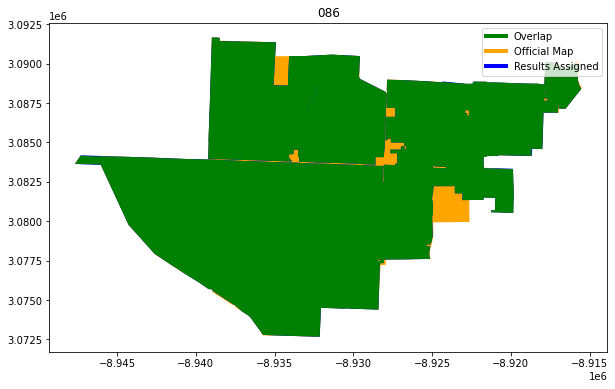

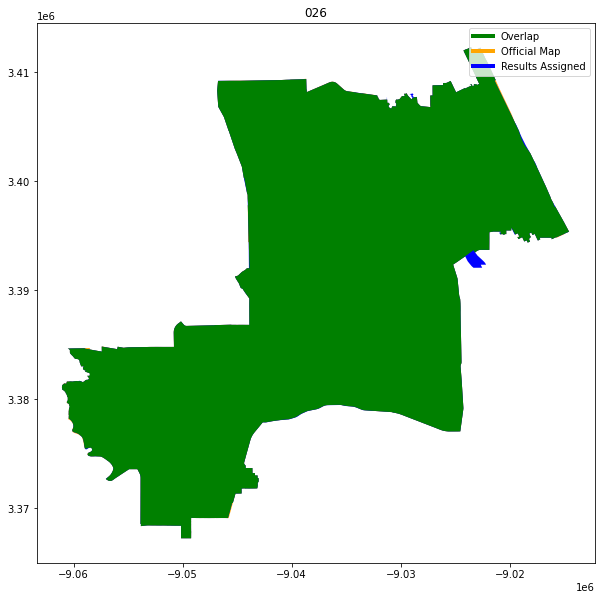

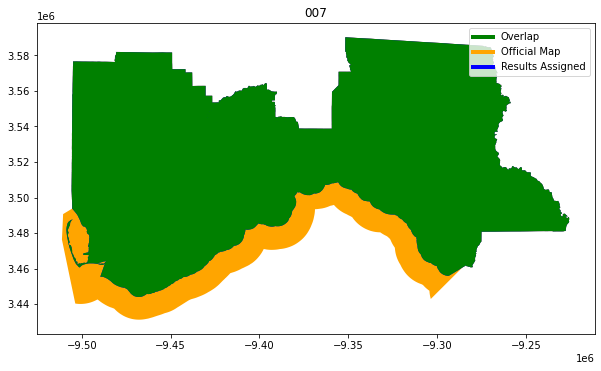

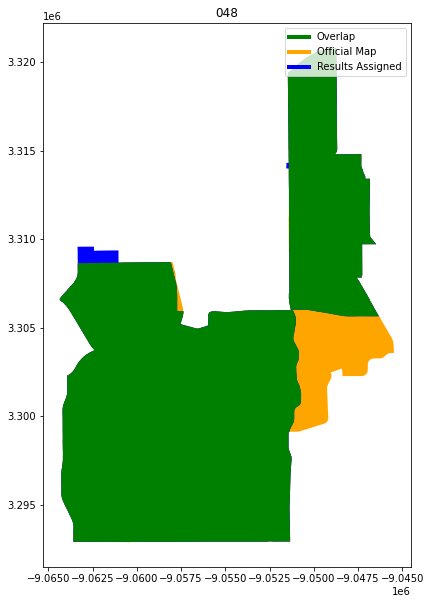

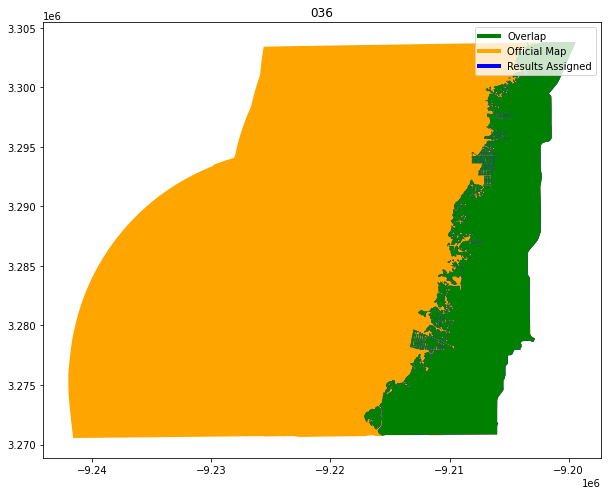

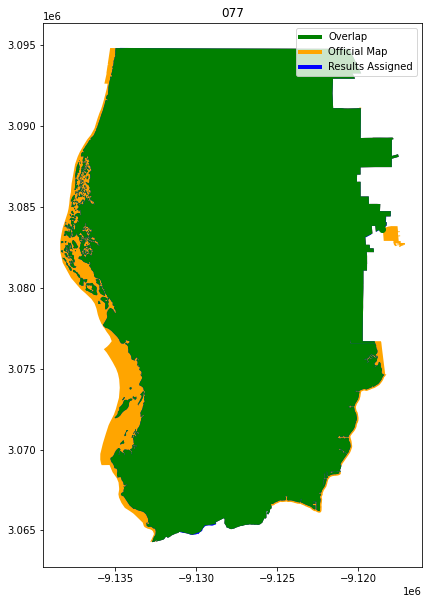

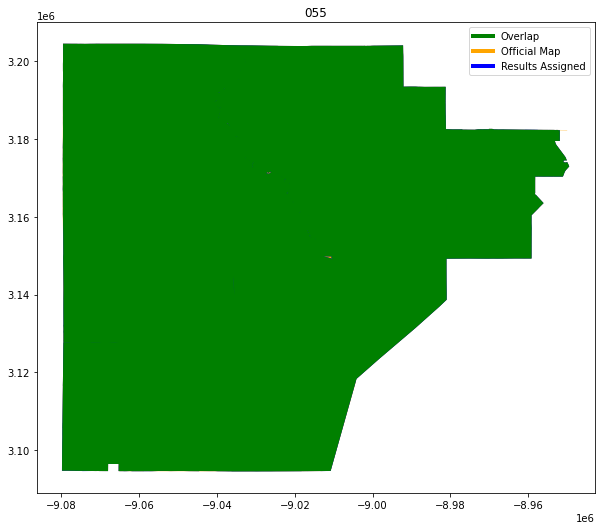

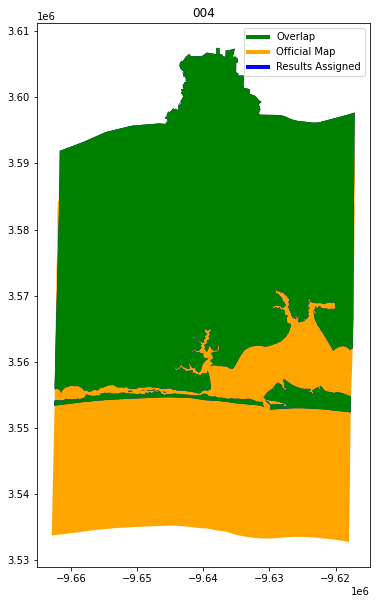

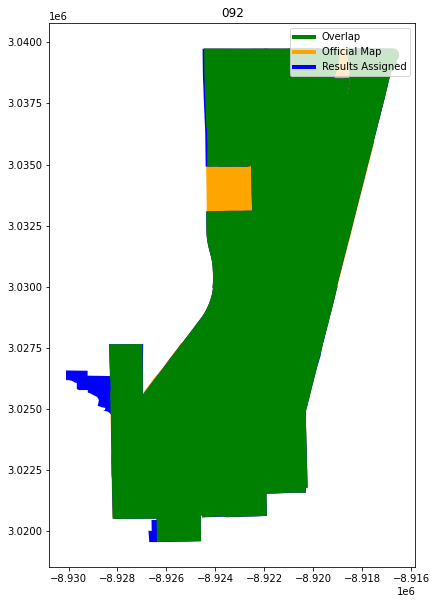

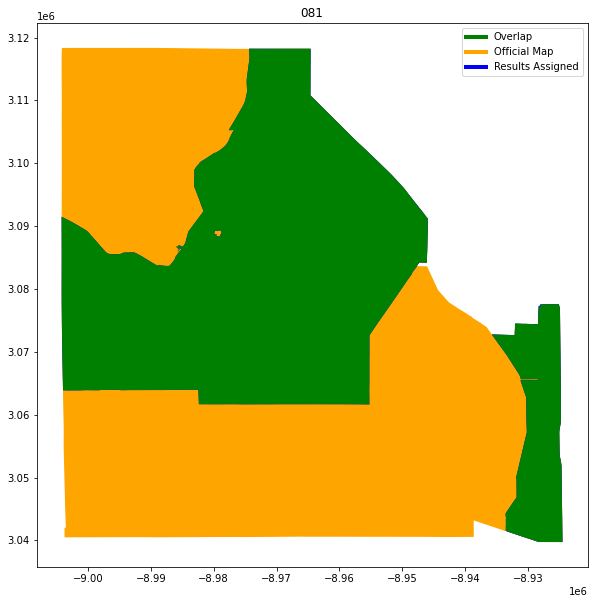

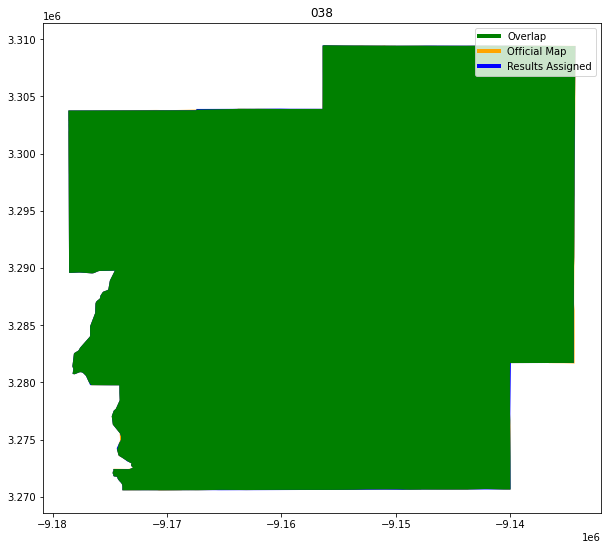

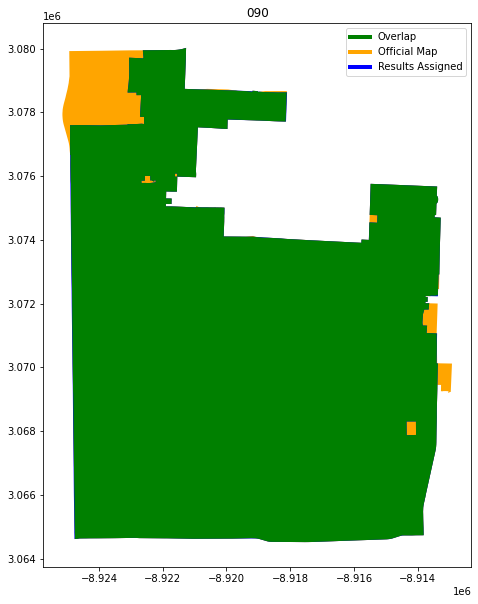

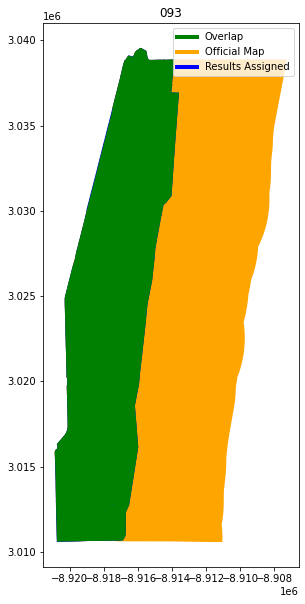

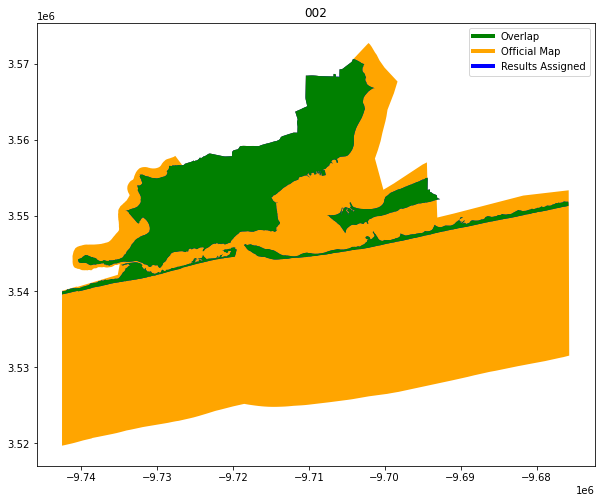

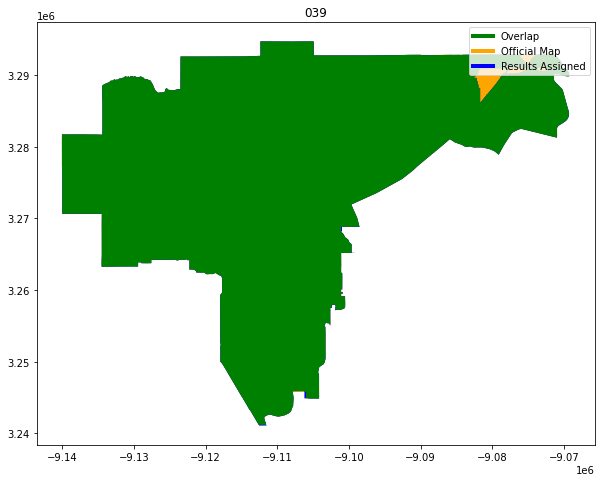

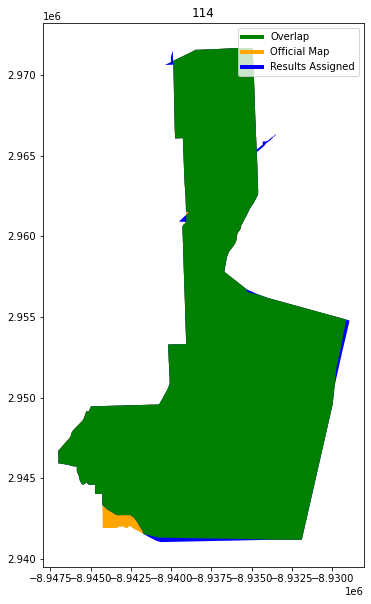

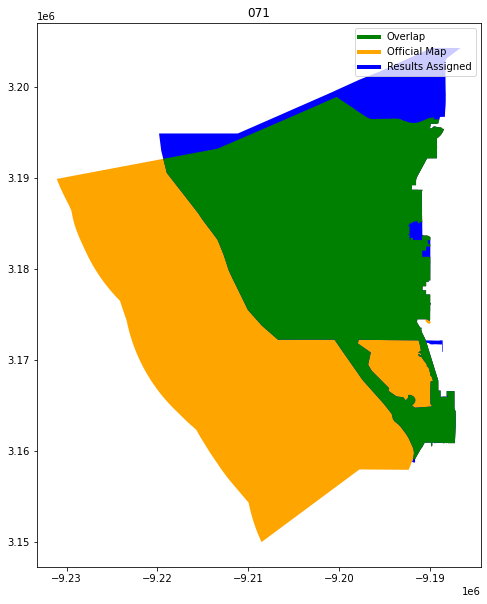

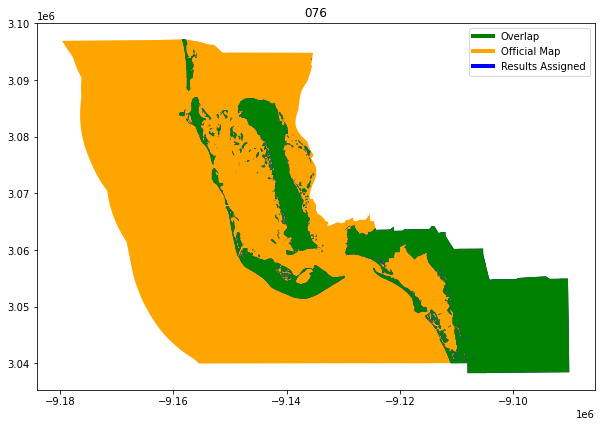

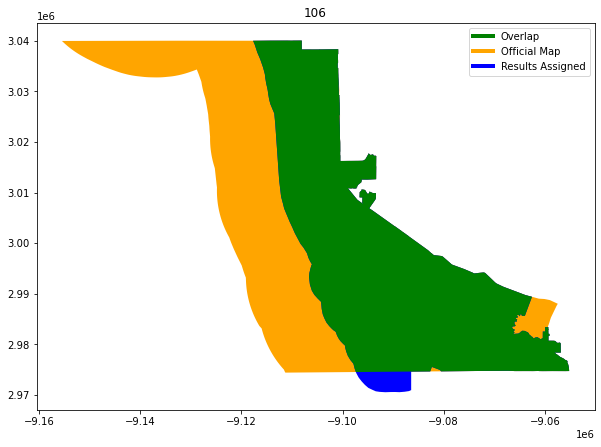

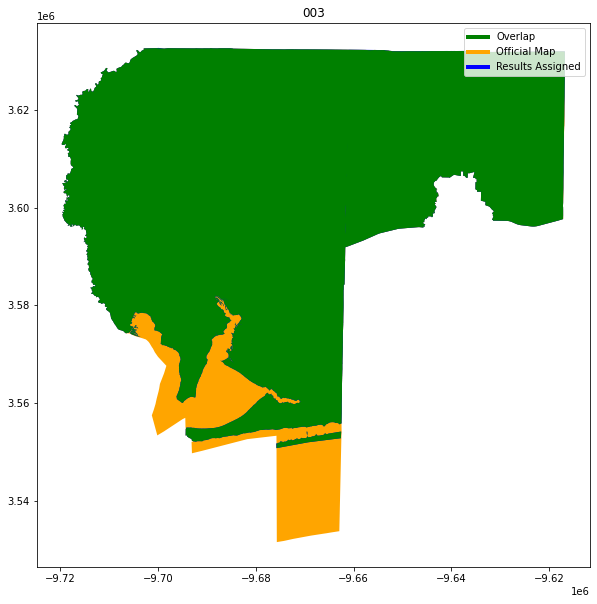

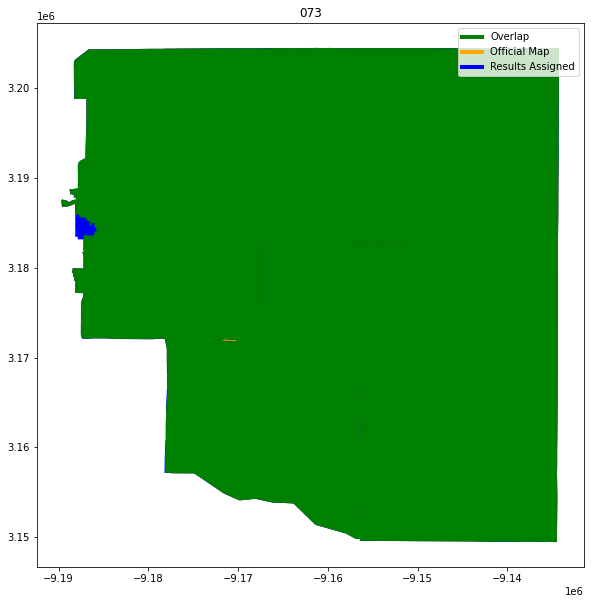

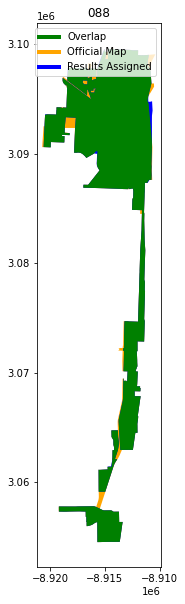

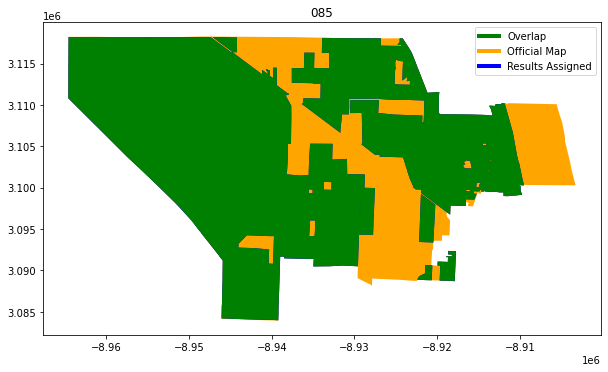

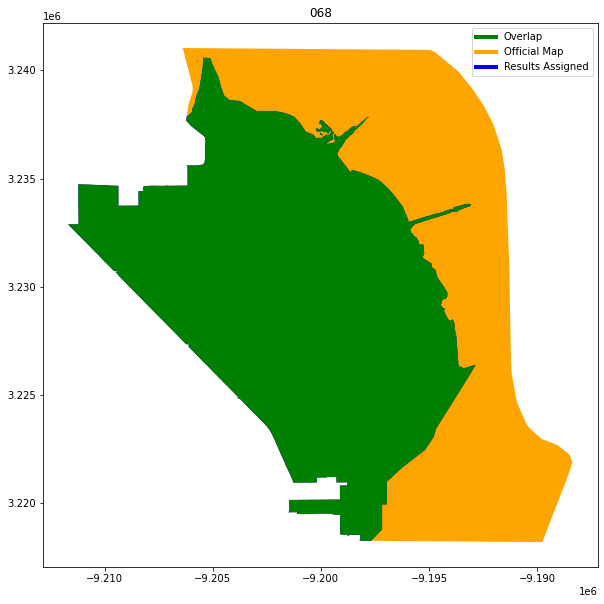

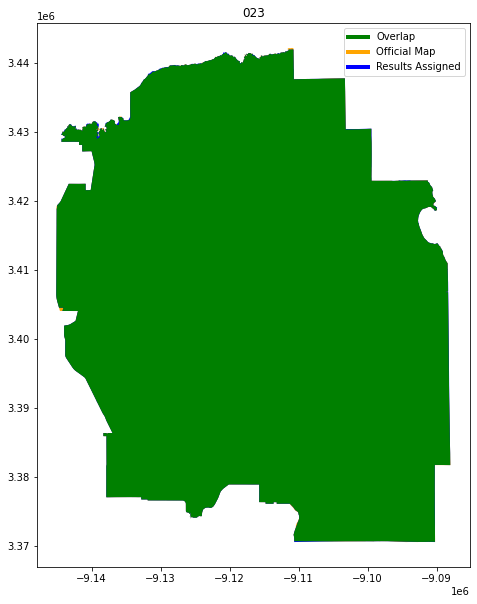

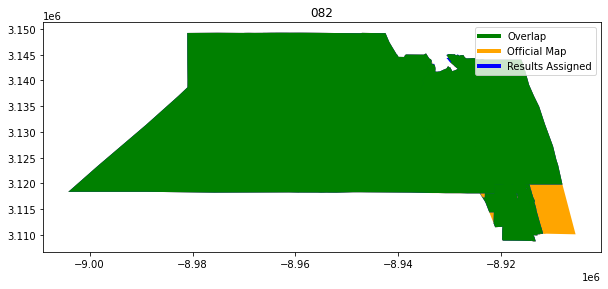

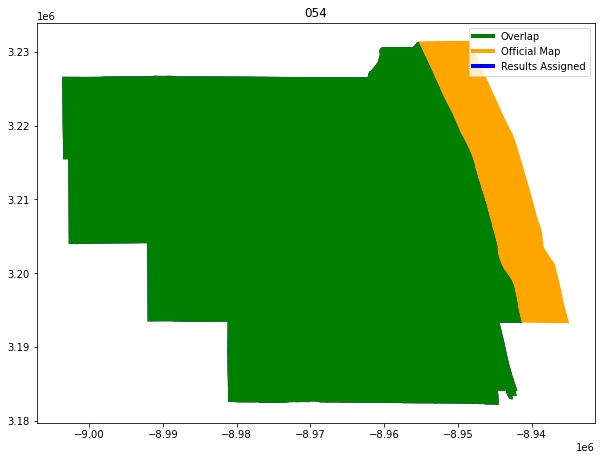

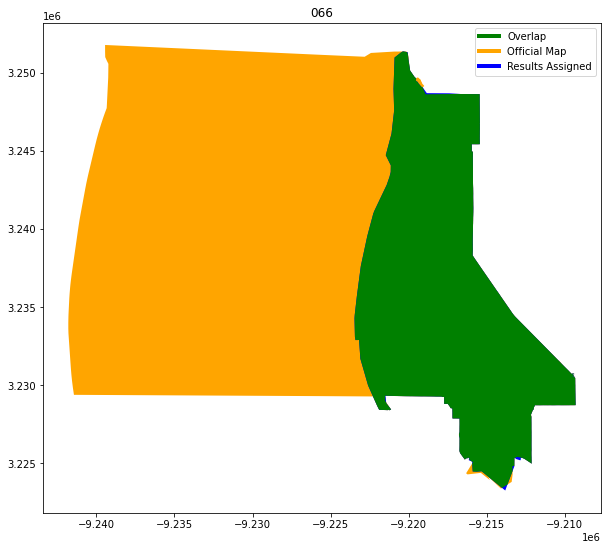

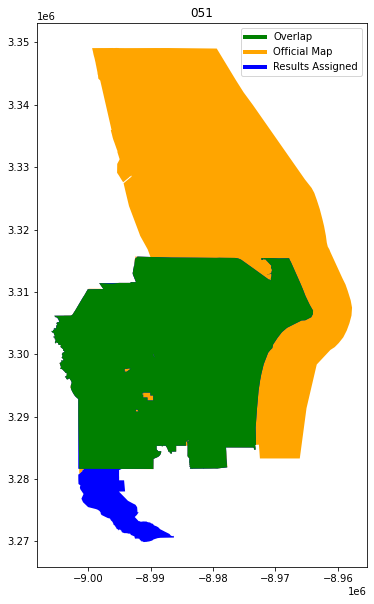

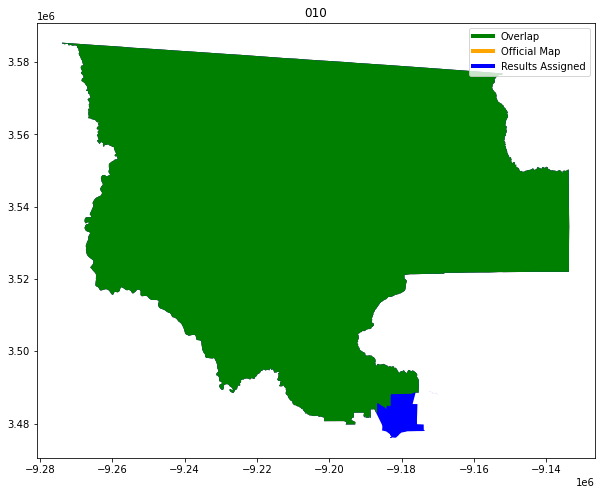

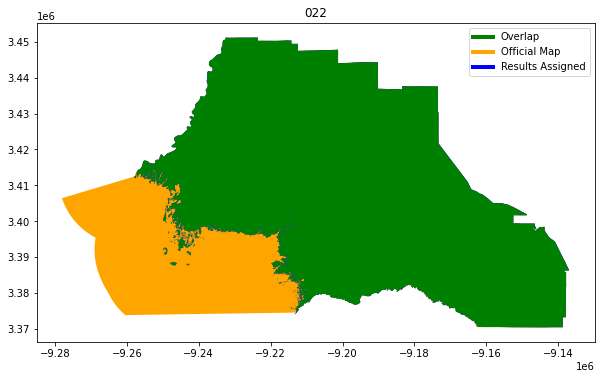

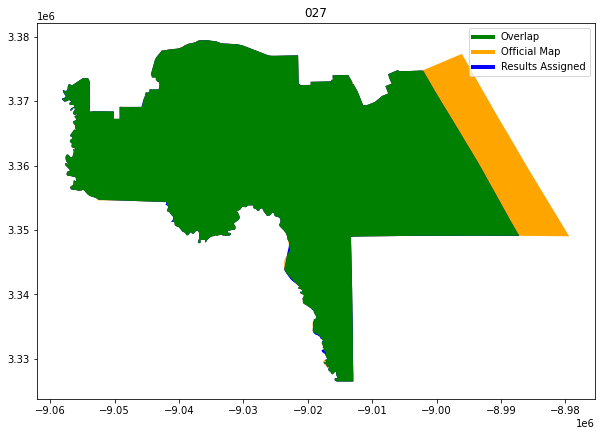

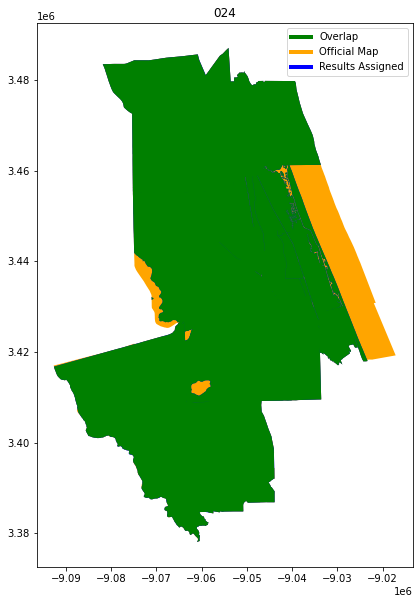

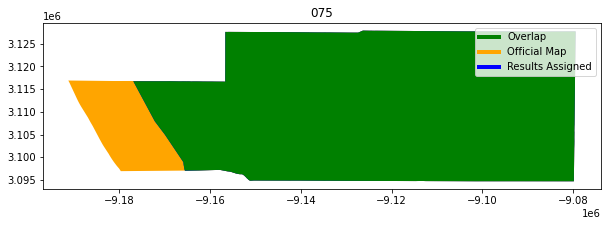

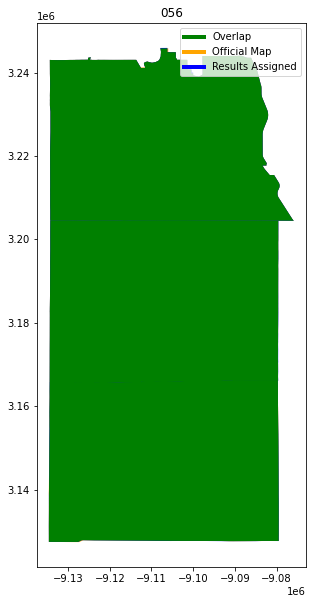

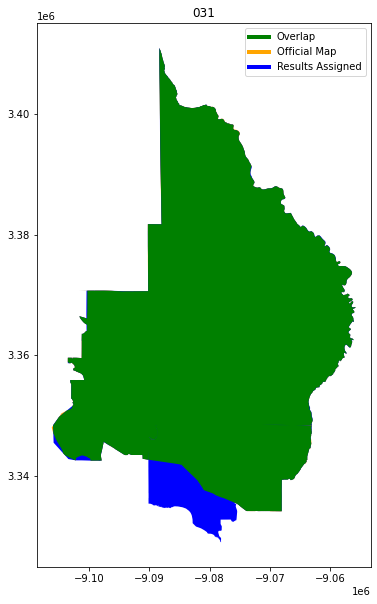

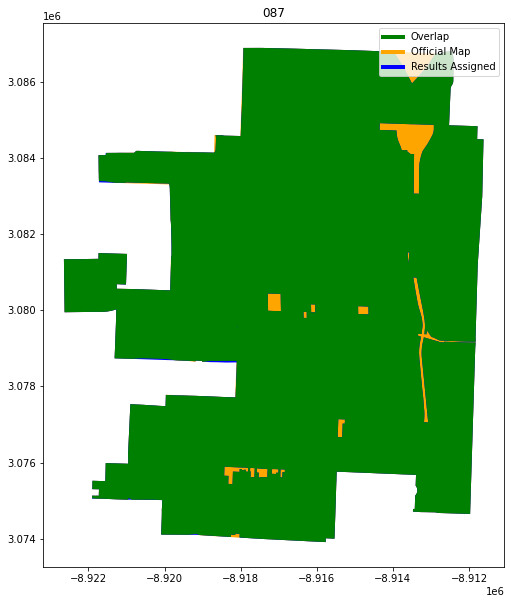

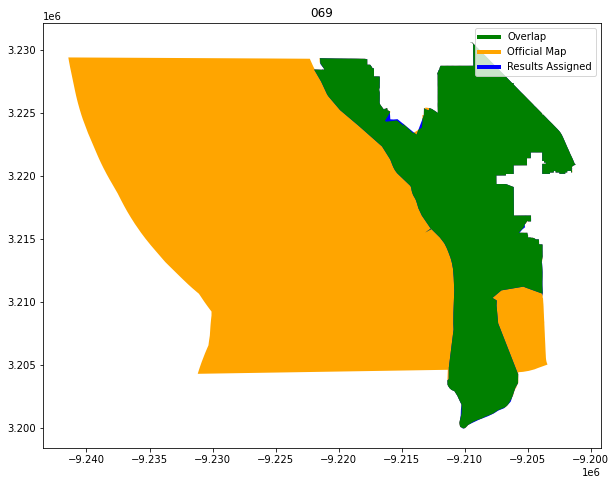

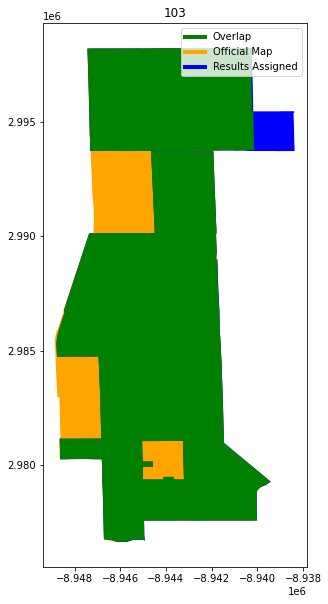

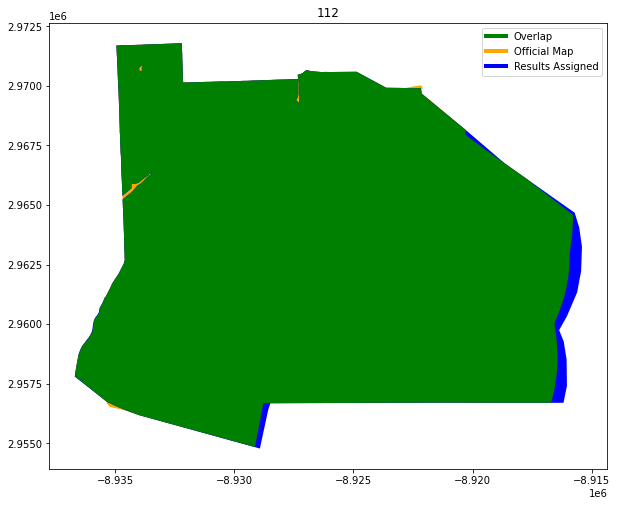

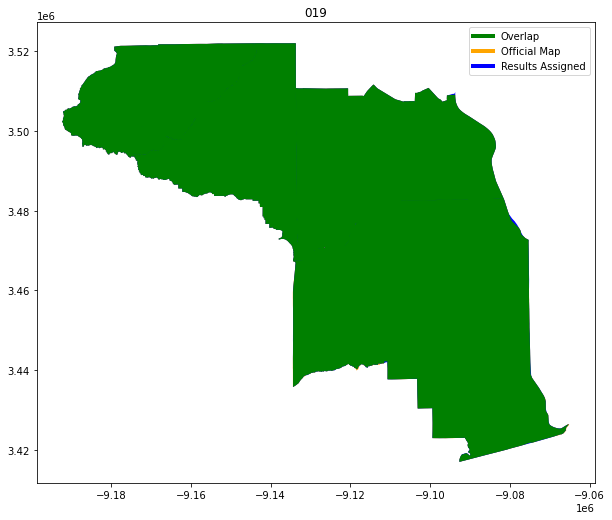

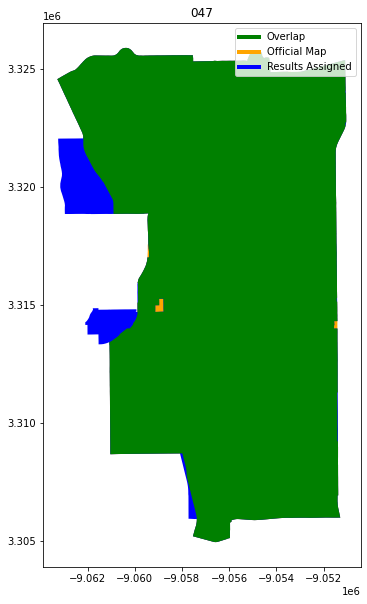

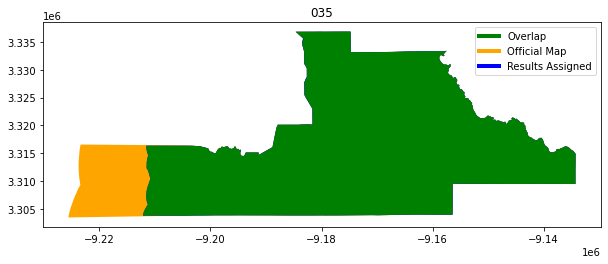

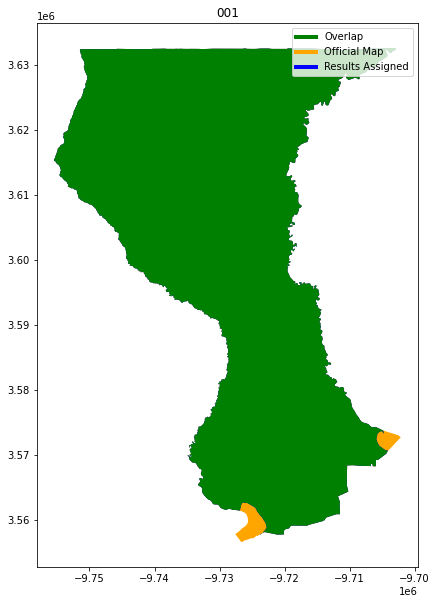

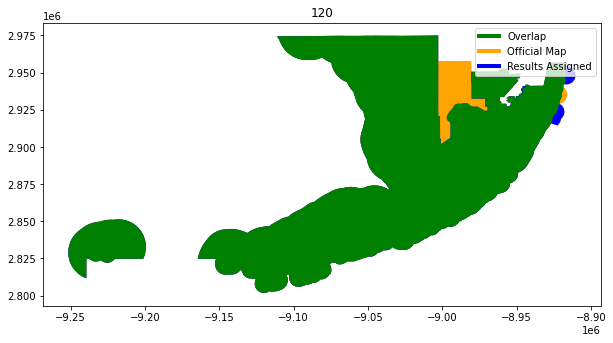

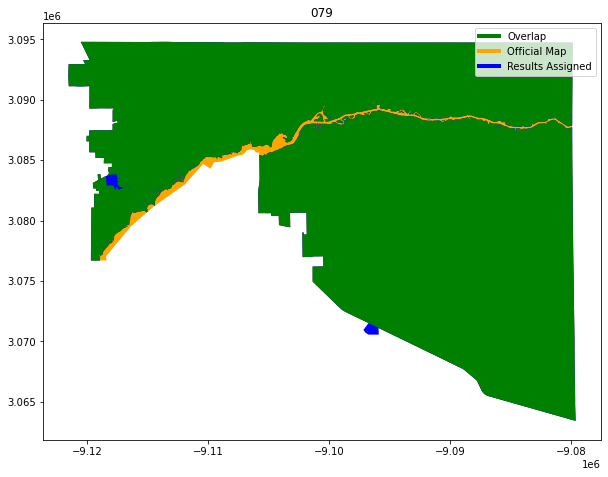

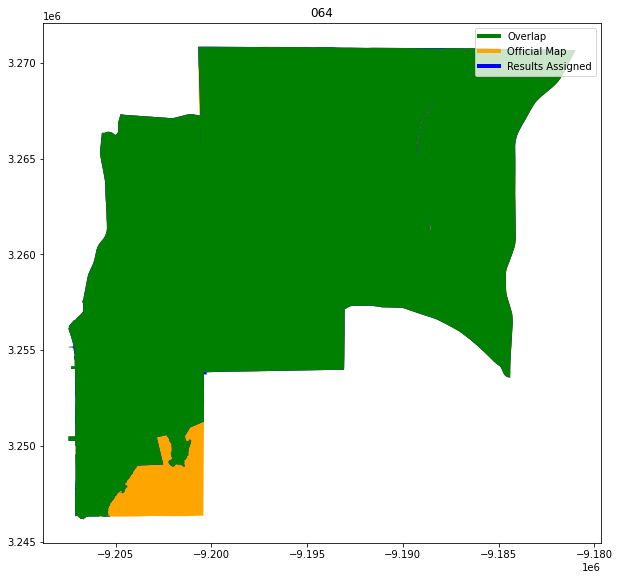

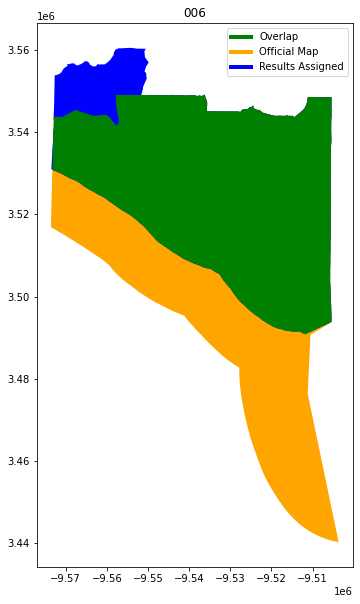

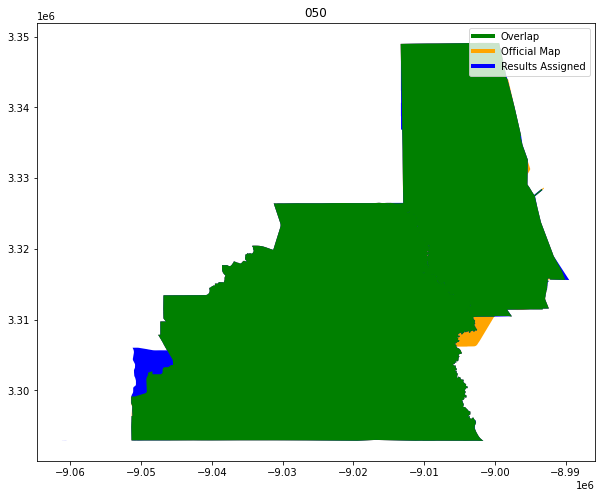

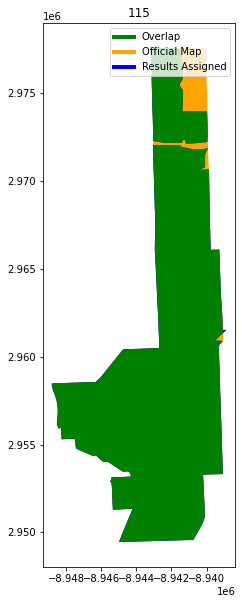

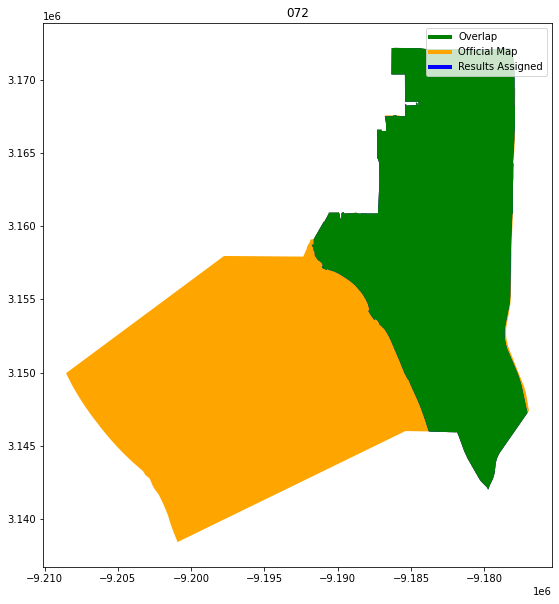

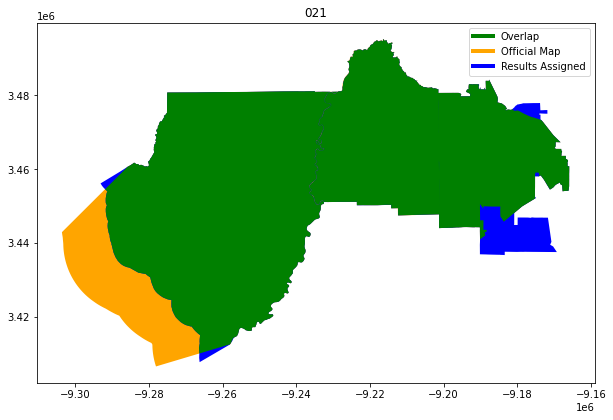

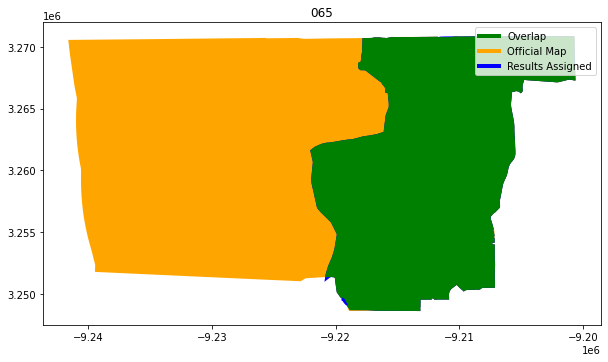

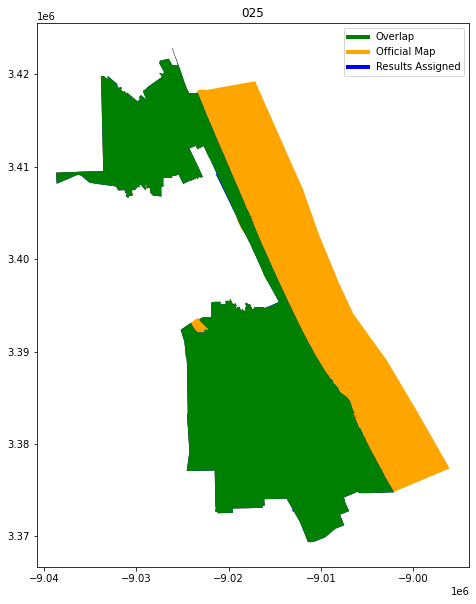

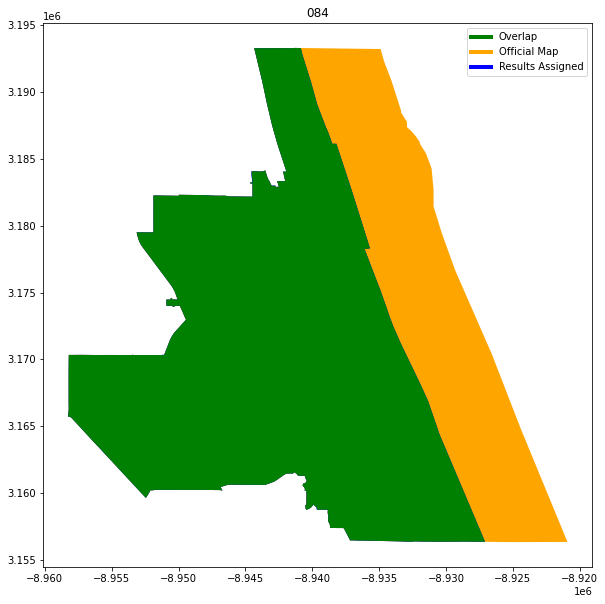

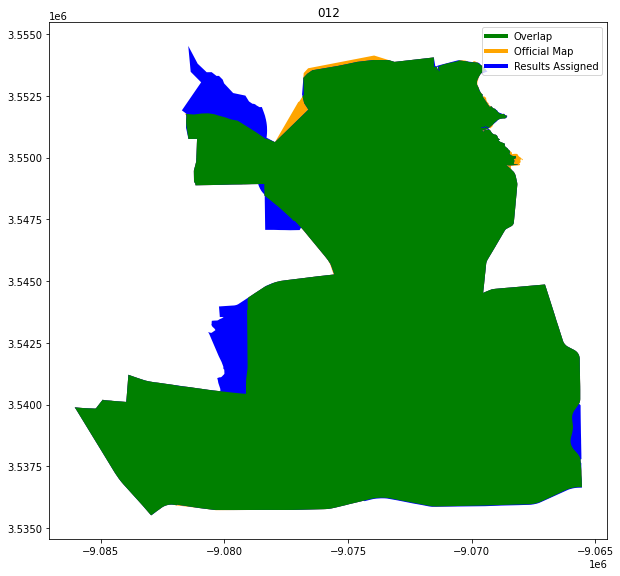

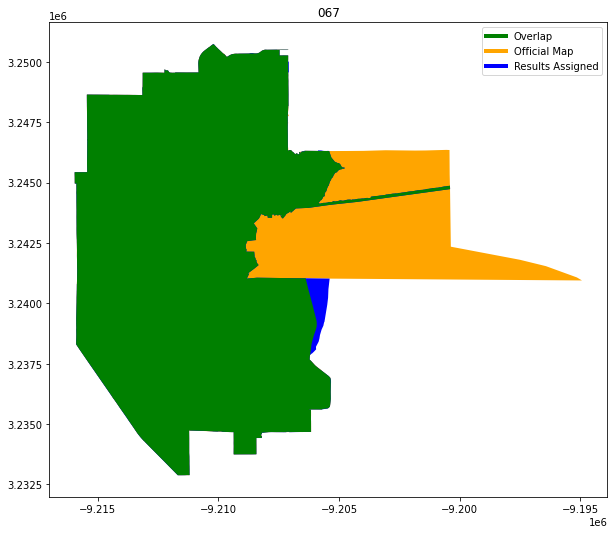

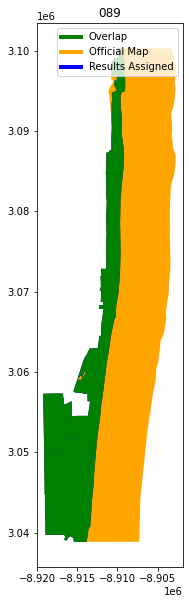

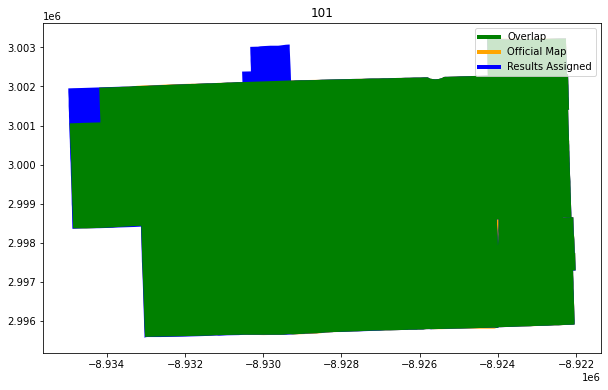

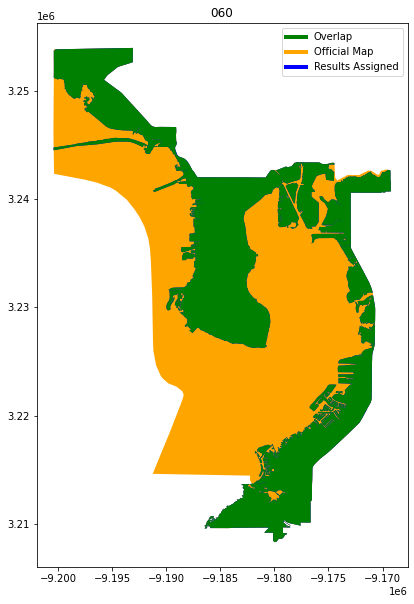

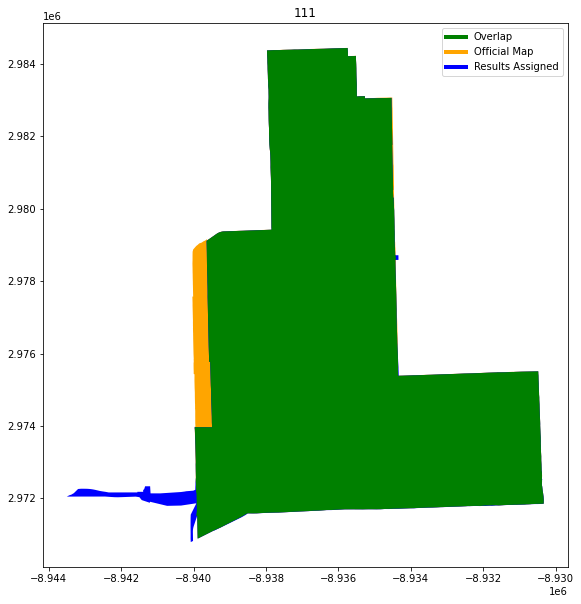

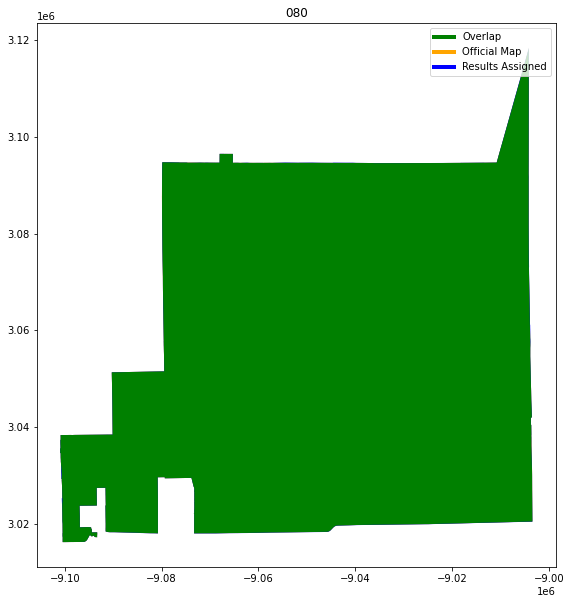

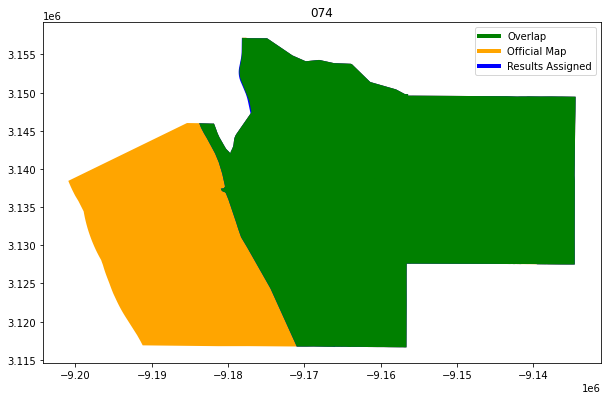

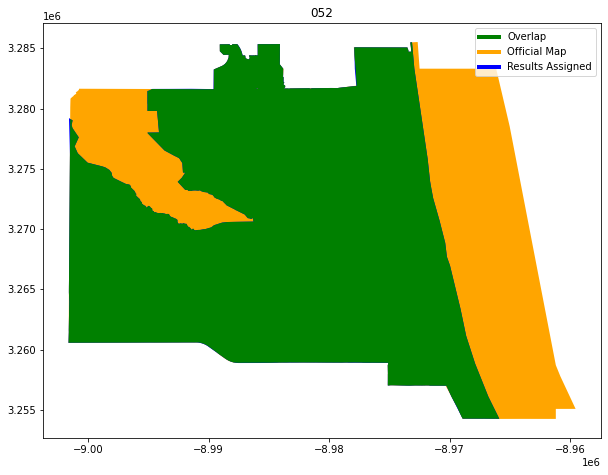

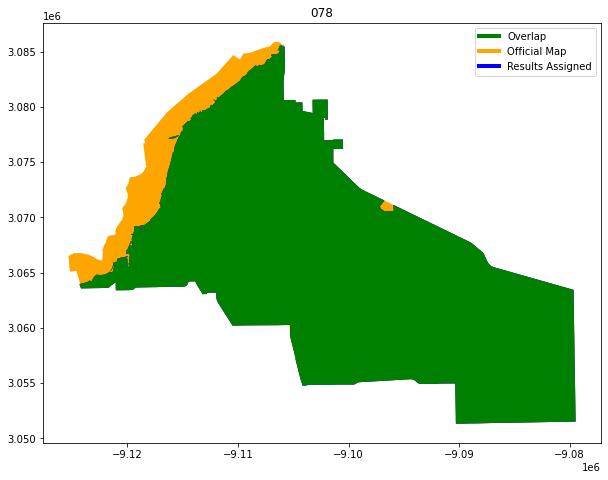

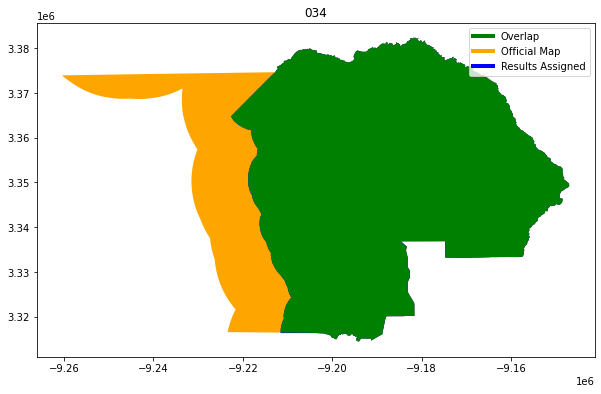

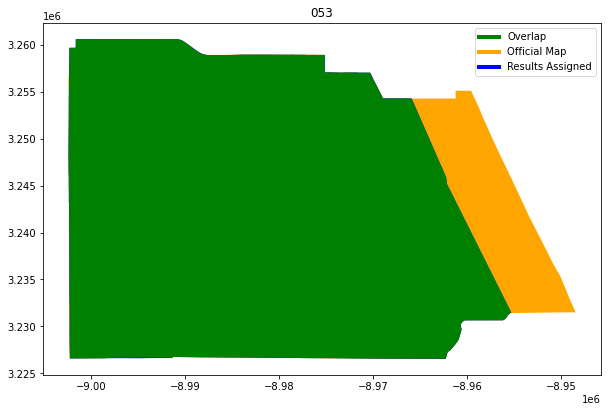

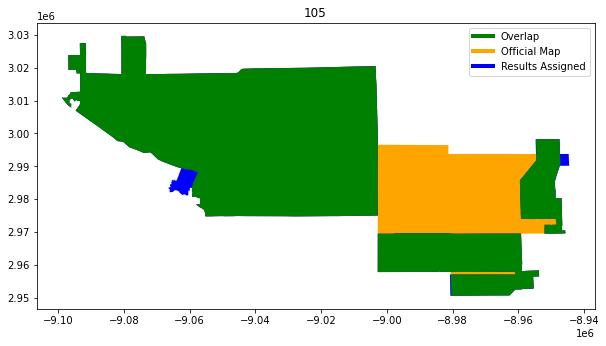

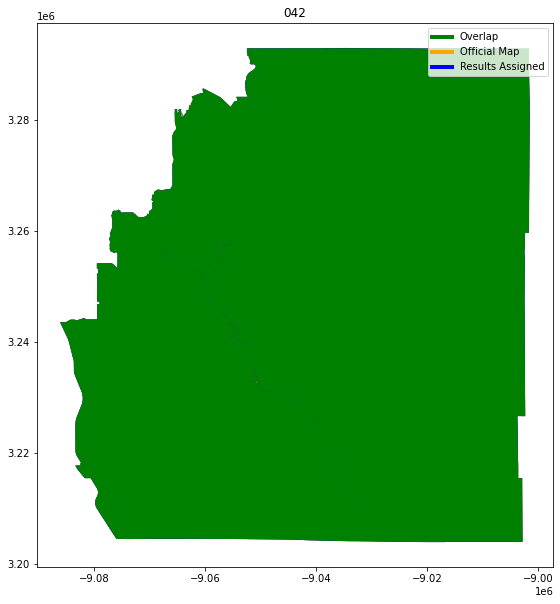

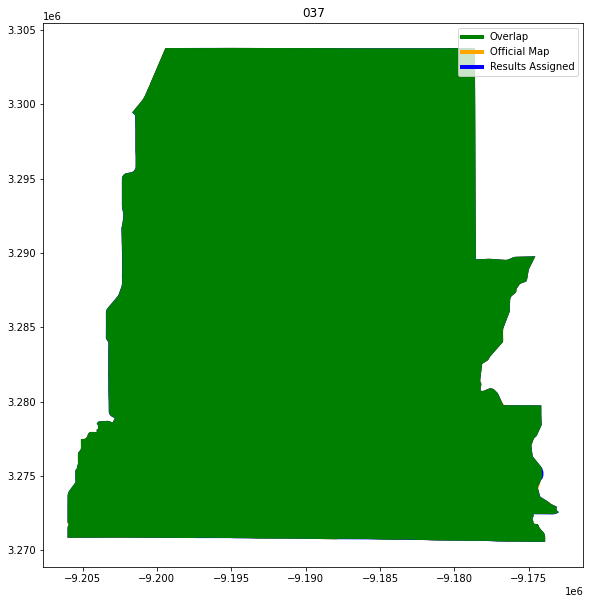

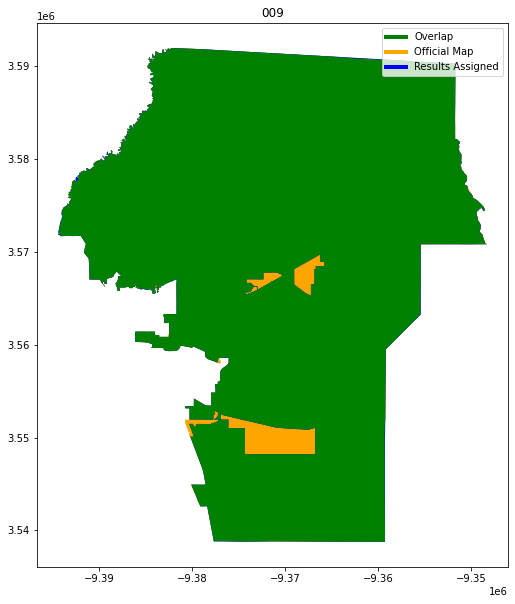

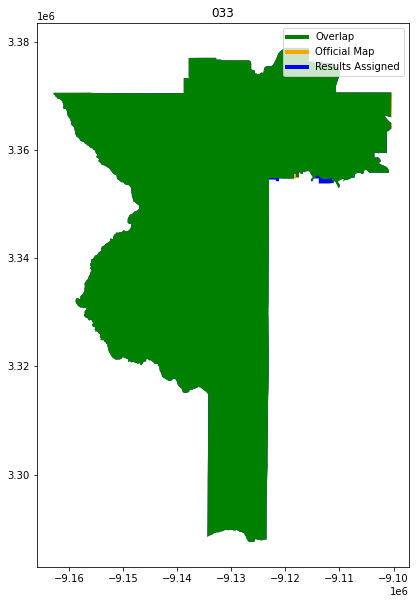

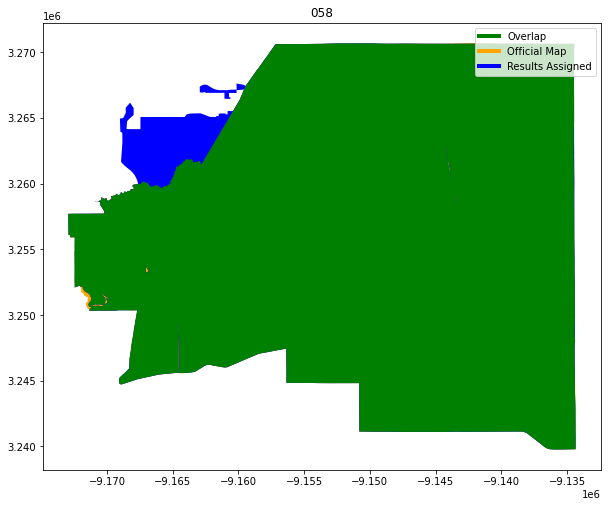

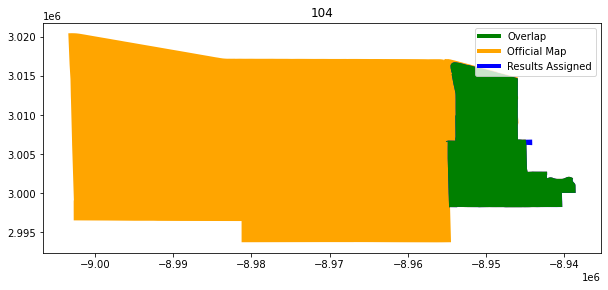

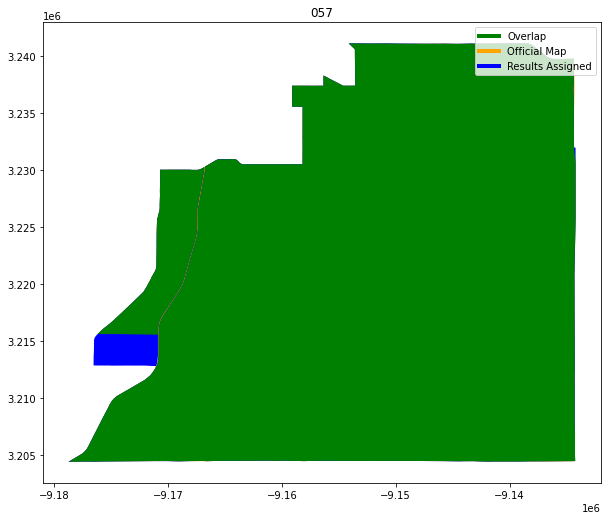

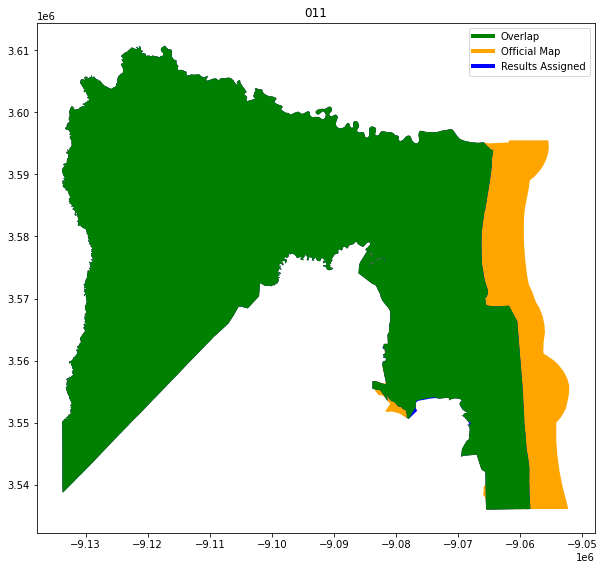

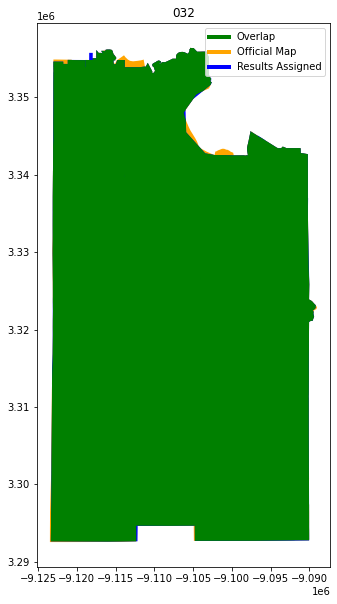

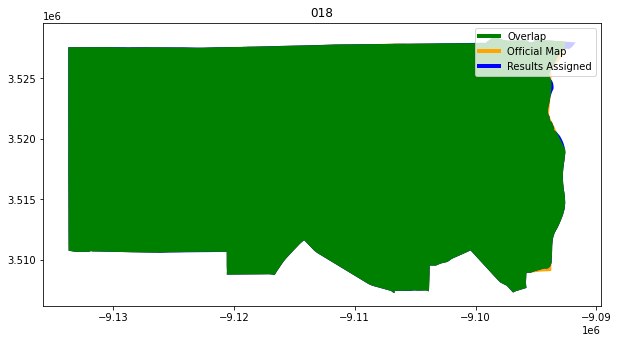

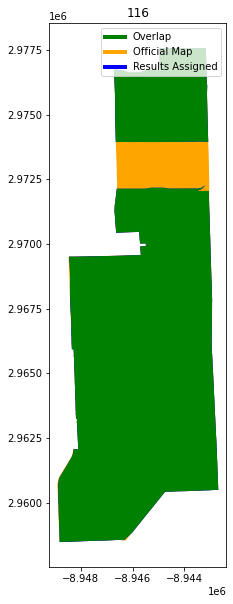

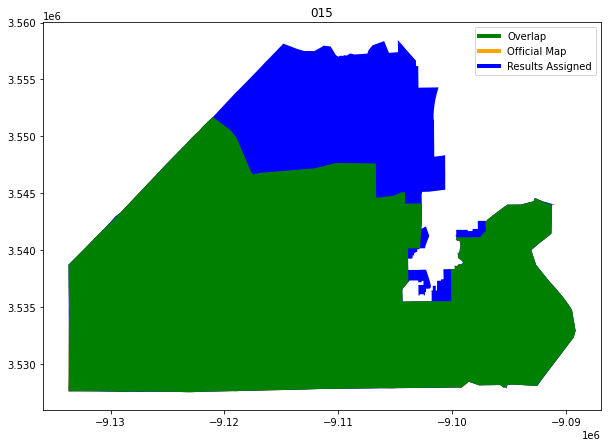

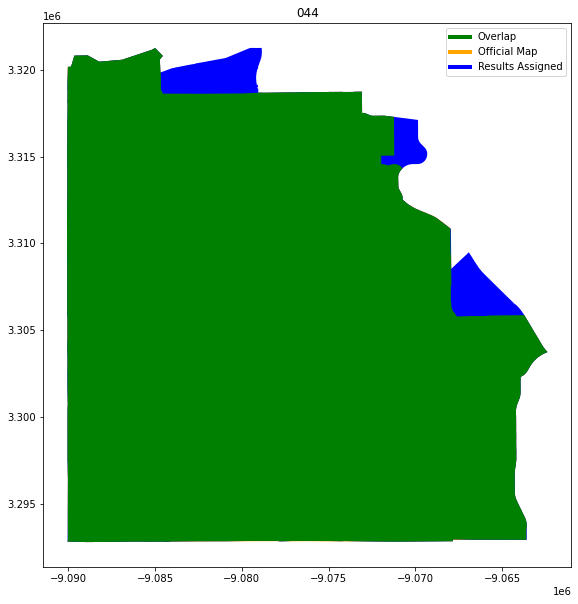

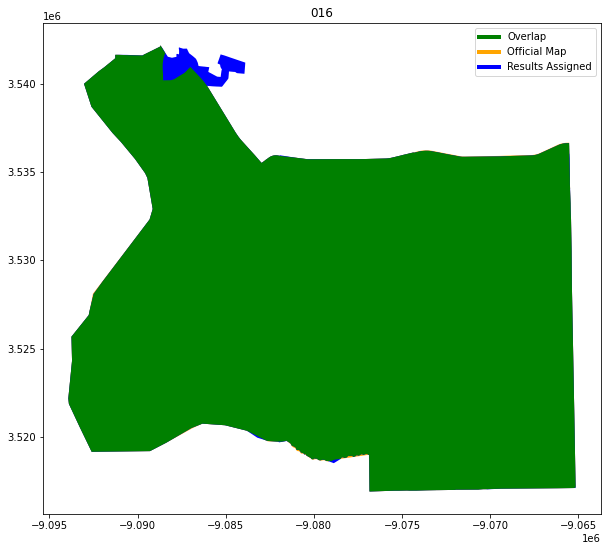

In [97]:
compare_geometries(fl_sldl_shapefile,filtered_results,"Official Map","Results Assigned","SLDL_DIST",area_threshold=.1)

## Election Totals Checks

In [98]:
tot_sum = 0
for val in state_data_columns:
    tot_sum += sum(join_attempt_two[val])
    print(val, sum(join_attempt_two[val]))

GSL001DMAT 30485
GSL001RSAL 57363
GSL002DKRU 39507
GSL002RAND 49953
GSL003DHOO 25929
GSL003RWIL 82702
GSL004DPLA 27083
GSL004OWRI 169
GSL004RMAN 70208
GSL006DBAY 23848
GSL006RTRU 61456
GSL007DKHA 20696
GSL007RSHO 55841
GSL009DTAN 58868
GSL009RKAL 42901
GSL010DABO 16456
GSL010RBRA 58872
GSL011DHIC 35686
GSL011RBYR 76422
GSL012DBLI 34391
GSL012RYAR 51715
GSL015DTHO 39000
GSL015RDUG 45360
GSL016DMAR 43901
GSL016RFIS 59549
GSL017DROG 46685
GSL017RSTE 97932
GSL018DEDW 28457
GSL018LWIL 3099
GSL018RGAR 64759
GSL019DDUG 21259
GSL019RPAY 58184
GSL021DENN 46817
GSL021RCLE 48883
GSL022DBYR 35011
GSL022RHAR 63520
GSL023DROS 28882
GSL023RMCC 58787
GSL024DMOR 41553
GSL024RREN 70884
GSL025DZUT 36696
GSL025LHAN 2407
GSL025RLEE 65675
GSL026DHEN 39164
GSL026RFET 44278
GSL027DGUZ 38583
GSL027RBAR 49486
GSL028DBAK 45288
GSL028NRIC 2049
GSL028RSMI 51350
GSL029DKAG 44619
GSL029NROD 2760
GSL029RPLA 48411
GSL030DGOF 46713
GSL030RCOR 41452
GSL031DSTI 39403
GSL031RTRU 58311
GSL032DDUK 50226
GSL032RSAB 63164
GSL

In [99]:
list(join_attempt_two.columns)

['UNIQUE_ID',
 'COUNTYFP',
 'pct_std',
 'county',
 'precinct',
 'GSL001DMAT',
 'GSL001RSAL',
 'GSL002DKRU',
 'GSL002RAND',
 'GSL003DHOO',
 'GSL003RWIL',
 'GSL004DPLA',
 'GSL004OWRI',
 'GSL004RMAN',
 'GSL006DBAY',
 'GSL006RTRU',
 'GSL007DKHA',
 'GSL007RSHO',
 'GSL009DTAN',
 'GSL009RKAL',
 'GSL010DABO',
 'GSL010RBRA',
 'GSL011DHIC',
 'GSL011RBYR',
 'GSL012DBLI',
 'GSL012RYAR',
 'GSL015DTHO',
 'GSL015RDUG',
 'GSL016DMAR',
 'GSL016RFIS',
 'GSL017DROG',
 'GSL017RSTE',
 'GSL018DEDW',
 'GSL018LWIL',
 'GSL018RGAR',
 'GSL019DDUG',
 'GSL019RPAY',
 'GSL021DENN',
 'GSL021RCLE',
 'GSL022DBYR',
 'GSL022RHAR',
 'GSL023DROS',
 'GSL023RMCC',
 'GSL024DMOR',
 'GSL024RREN',
 'GSL025DZUT',
 'GSL025LHAN',
 'GSL025RLEE',
 'GSL026DHEN',
 'GSL026RFET',
 'GSL027DGUZ',
 'GSL027RBAR',
 'GSL028DBAK',
 'GSL028NRIC',
 'GSL028RSMI',
 'GSL029DKAG',
 'GSL029NROD',
 'GSL029RPLA',
 'GSL030DGOF',
 'GSL030RCOR',
 'GSL031DSTI',
 'GSL031RTRU',
 'GSL032DDUK',
 'GSL032RSAB',
 'GSL033DMEL',
 'GSL033RHAG',
 'GSL034DGOS',
 'GSL03

In [100]:
def county_totals_check(source_df,column_list,county_col,full_print=False):
    """Compares the totals of two election result dataframes at the county level

    Args:
      partner_df: DataFrame of election results we are comparing against
      source_df: DataFrame of election results we are comparing to
      column_list: List of races that there are votes for
      county_col: String of the column name that contains county information
      full_print: Boolean specifying whether to print out everything, including counties w/ similarities

    Returns:
      Nothing, only prints out an analysis
    """
    
    print("***Countywide Totals Check***")
    print("")
    diff_counties=[]
    for race in column_list:
        print(race)
        diff = source_df.groupby([county_col]).sum()[race]
        for val in diff.index.values.tolist():
            if val in ["MON","SEM"]:
                print("\t"+val + ": "+ str(source_df.groupby([county_col]).sum().loc[val,race])+" votes")

In [101]:
county_totals_check(join_attempt_two,state_data_columns,"county",True)

***Countywide Totals Check***

GSL001DMAT
	MON: 0 votes
	SEM: 0 votes
GSL001RSAL
	MON: 0 votes
	SEM: 0 votes
GSL002DKRU
	MON: 0 votes
	SEM: 0 votes
GSL002RAND
	MON: 0 votes
	SEM: 0 votes
GSL003DHOO
	MON: 0 votes
	SEM: 0 votes
GSL003RWIL
	MON: 0 votes
	SEM: 0 votes
GSL004DPLA
	MON: 0 votes
	SEM: 0 votes
GSL004OWRI
	MON: 0 votes
	SEM: 0 votes
GSL004RMAN
	MON: 0 votes
	SEM: 0 votes
GSL006DBAY
	MON: 0 votes
	SEM: 0 votes
GSL006RTRU
	MON: 0 votes
	SEM: 0 votes
GSL007DKHA
	MON: 0 votes
	SEM: 0 votes
GSL007RSHO
	MON: 0 votes
	SEM: 0 votes
GSL009DTAN
	MON: 0 votes
	SEM: 0 votes
GSL009RKAL
	MON: 0 votes
	SEM: 0 votes
GSL010DABO
	MON: 0 votes
	SEM: 0 votes
GSL010RBRA
	MON: 0 votes
	SEM: 0 votes
GSL011DHIC
	MON: 0 votes
	SEM: 0 votes
GSL011RBYR
	MON: 0 votes
	SEM: 0 votes
GSL012DBLI
	MON: 0 votes
	SEM: 0 votes
GSL012RYAR
	MON: 0 votes
	SEM: 0 votes
GSL015DTHO
	MON: 0 votes
	SEM: 0 votes
GSL015RDUG
	MON: 0 votes
	SEM: 0 votes
GSL016DMAR
	MON: 0 votes
	SEM: 0 votes
GSL016RFIS
	MON: 0 votes
	SEM: 0 

In [102]:
join_attempt_two = join_attempt_two[['UNIQUE_ID',
 'COUNTYFP',
 'pct_std',
 'county',
 'precinct',
 'SLDL_DIST',
 'GSL001DMAT',
 'GSL001RSAL',
 'GSL002DKRU',
 'GSL002RAND',
 'GSL003DHOO',
 'GSL003RWIL',
 'GSL004DPLA',
 'GSL004OWRI',
 'GSL004RMAN',
 'GSL006DBAY',
 'GSL006RTRU',
 'GSL007DKHA',
 'GSL007RSHO',
 'GSL009DTAN',
 'GSL009RKAL',
 'GSL010DABO',
 'GSL010RBRA',
 'GSL011DHIC',
 'GSL011RBYR',
 'GSL012DBLI',
 'GSL012RYAR',
 'GSL015DTHO',
 'GSL015RDUG',
 'GSL016DMAR',
 'GSL016RFIS',
 'GSL017DROG',
 'GSL017RSTE',
 'GSL018DEDW',
 'GSL018LWIL',
 'GSL018RGAR',
 'GSL019DDUG',
 'GSL019RPAY',
 'GSL021DENN',
 'GSL021RCLE',
 'GSL022DBYR',
 'GSL022RHAR',
 'GSL023DROS',
 'GSL023RMCC',
 'GSL024DMOR',
 'GSL024RREN',
 'GSL025DZUT',
 'GSL025LHAN',
 'GSL025RLEE',
 'GSL026DHEN',
 'GSL026RFET',
 'GSL027DGUZ',
 'GSL027RBAR',
 'GSL028DBAK',
 'GSL028NRIC',
 'GSL028RSMI',
 'GSL029DKAG',
 'GSL029NROD',
 'GSL029RPLA',
 'GSL030DGOF',
 'GSL030RCOR',
 'GSL031DSTI',
 'GSL031RTRU',
 'GSL032DDUK',
 'GSL032RSAB',
 'GSL033DMEL',
 'GSL033RHAG',
 'GSL034DGOS',
 'GSL034RMAS',
 'GSL035DLAU',
 'GSL035RING',
 'GSL036DEND',
 'GSL036RMAR',
 'GSL037DGAR',
 'GSL037RZIK',
 'GSL038DSTA',
 'GSL038RMAG',
 'GSL039DCAU',
 'GSL039RTOM',
 'GSL040DBAR',
 'GSL040NMIC',
 'GSL040RBUR',
 'GSL041DWES',
 'GSL041RKIL',
 'GSL042DCAD',
 'GSL042NSAN',
 'GSL042RHAW',
 'GSL044DTHO',
 'GSL044RPOR',
 'GSL047DESK',
 'GSL047RSIS',
 'GSL048DMOR',
 'GSL048RMAR',
 'GSL049DSMI',
 'GSL049RPRA',
 'GSL050DYOA',
 'GSL050RPLA',
 'GSL051DMAJ',
 'GSL051RSIR',
 'GSL052DDAB',
 'GSL052RALT',
 'GSL053DMOO',
 'GSL053OWRI',
 'GSL053RFIN',
 'GSL054DGRI',
 'GSL054RGRA',
 'GSL055DTRI',
 'GSL055OWRI',
 'GSL055RTUC',
 'GSL056DDAV',
 'GSL056RBEL',
 'GSL057DHOT',
 'GSL057RBEL',
 'GSL058DTOW',
 'GSL058RMCC',
 'GSL059DLEA',
 'GSL059ROWE',
 'GSL060DJEN',
 'GSL060RTOL',
 'GSL062DVAL',
 'GSL062NROD',
 'GSL062RCAP',
 'GSL064DHAR',
 'GSL064RKOS',
 'GSL065DJOH',
 'GSL065RSPR',
 'GSL066DPLA',
 'GSL066RDIC',
 'GSL067DDOU',
 'GSL067RLAT',
 'GSL068DDIA',
 'GSL068RTIT',
 'GSL069DWEB',
 'GSL069RCHA',
 'GSL071DMEL',
 'GSL071RROB',
 'GSL072DBUC',
 'GSL072RMCF',
 'GSL073DFAI',
 'GSL073RGRE',
 'GSL074DSTO',
 'GSL074RBUC',
 'GSL075DJON',
 'GSL075RGRA',
 'GSL076DWEB',
 'GSL076RBOT',
 'GSL077DLOP',
 'GSL077RGIA',
 'GSL078DWIL',
 'GSL078RPER',
 'GSL079DFOR',
 'GSL079RROA',
 'GSL080DNOV',
 'GSL080RMEL',
 'GSL081DSKI',
 'GSL081RBAN',
 'GSL082DACK',
 'GSL082RSNY',
 'GSL083DBER',
 'GSL083ROVE',
 'GSL084DJOH',
 'GSL084RTRA',
 'GSL085DCAR',
 'GSL085RROT',
 'GSL086DWIL',
 'GSL086RRIV',
 'GSL087DSIL',
 'GSL087RSEN',
 'GSL088DHAR',
 'GSL088NAND',
 'GSL088RMAD',
 'GSL089DBON',
 'GSL089RCAR',
 'GSL090DCAS',
 'GSL090RMAL',
 'GSL091DSLO',
 'GSL091RHUS',
 'GSL092DHAW',
 'GSL092NCLA',
 'GSL093DGON',
 'GSL093RLAM',
 'GSL101DWOO',
 'GSL101RPAR',
 'GSL103DPOL',
 'GSL103RFAB',
 'GSL104DBAR',
 'GSL104RNAV',
 'GSL105DPOR',
 'GSL105RBOR',
 'GSL106DMCF',
 'GSL106RROM',
 'GSL110DCOL',
 'GSL110RRIZ',
 'GSL111DHAN',
 'GSL111RAVI',
 'GSL112DDUR',
 'GSL112RBAR',
 'GSL114DJEA',
 'GSL114RCAB',
 'GSL115DCES',
 'GSL115RALO',
 'GSL116DLYN',
 'GSL116OWRI',
 'GSL116RPER',
 'GSL118DJUN',
 'GSL118RROD',
 'GSL119DMOH',
 'GSL119RFER',
 'GSL120DBAR',
 'GSL120RMOO',
 'geometry']]

## Export File

In [104]:
if not os.path.exists('./fl_gen_20_prec/'):
    os.mkdir('./fl_gen_20_prec/')

join_attempt_two.to_file('./fl_gen_20_prec/fl_gen_20_sldl_prec.shp')